# Columndescription 

In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd

import numpy as np
import warnings
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
import gc

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

warnings.filterwarnings('ignore')

In [2]:
#def get_labels to number(row, threshold):
#    result_dict = dict()
#    for labels, number in zip(row['labels'], row['scores']):
#        if _score > threshold:
#            result_dict.update({labels: 1})
#        else:
#            result_dict.update({labels: 0})
#    return result_dict

In [3]:
articles = pd.read_csv("../data/articles.csv").sort_values ("article_id").reset_index(drop=True)
custom = pd.read_csv("../data/customers.csv").sort_values("customer_id").reset_index(drop=True)
trans= pd.read_csv("../data/transactions_train.csv",parse_dates=['t_dat']).sort_values("customer_id").reset_index(drop=True)
sample=pd.read_csv("../data/sample_submission.csv").sort_values("customer_id").reset_index(drop=True)

## General description

* [Articles](#articles) describes the articles and possible categorization
* [Customer](#customer) gives information about the Customers connected to H&M
* [Transactions](#transaction) gives information about each transaction process connected to the _Customer_ and _Articles_
* [Sample](#sample) represents the prediction sample 12 recommentions for each customer

### Columns by each Dataframe

#### Articles Columns

|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
| [article_id](#articleid) 	|int64 | Id connected to image name| 105542| |
| [product_code](#productcode)	|int64| Overlying product category| 45875| Takes the first 7 digits of the article ID|
| [prod_name](#prodname)	|object |  overall product name | 47224| General product name|
|[product_type_no](#producttypeno)	|int64 | Classificaton after product type number| 132| -1 = unknown = NaN ? = 121||
|[product_type_name](#producttypename)	|object |Classificaton product type label| 131| 131 values + -1 for unknown |
|[product_group_name](#productgroupname)	|object | Product typ categories by name|19| 121 unknown |
| [graphical_appearance_no](#graphicalappearanceno)	| int64| Appearance no| 30| -1 = unknown = NaN ? = 52|
|[graphical_appearance_name](#graphicalappearancename)	|object| Appearance label| 30| |
| [colour_group_code](#colourgroupcode)	|int64| (dominating)Colour group number|50| No closed numbers i.e. 18, 24-29, 34-39 etc. is missing|
| [colour_group_name](#colourgroupname)	|object| (dominating)Colour group label| 50| |
|[perceived_colour_value_id](#perceivedcolourvalueid)	|int64| "gray" scale or lightning condition of the image| 8 | -1 = unknown = NaN? = 105542|
|[perceived_colour_value_name](#perceivedcolourvaluename)	|object| description of the lightning condition label| 8 | | |
|[perceived_colour_master_id](#perceivedcolourmasterid)	|int64|color master id | 20 | 17 is missing and -1 = unknown|
|[perceived_colour_master_name](#perceivedcolourmastername)	|object|  label of the color master id |20 | 
|[department_no](#departmentno)	|int64| Department number| 299| More than one department might be responsible for  a certain topic| 
|[department_name](#departmentname)	|object| Department label (topics) |250| |
|[index_code](#indexcode)	|object| "target group classification" index code| 10| A-F|
|[index_name](#indexname)	|object| "target group classification"  index label | 10 | Ladieswear, Menswear etc.| 
|[index_group_no](#indexgroupno)	|int64| Corse "target group classification"  |5| 1,2,3,4,26|
| [index_group_name](#indexgroupname)	|object| Corse "target group classification"  label | 5|  'Ladieswear' = 1 ,'Divided' =2,'Menswear'=3 'Baby/Children' = 4 , 'Sport' =26|
| [section_no](#sectionno)	|int64| "target group classification" + usage numbering| 57| not a closed numbering|
| [section_name](#sectionname)	|object| "target group classification" + usage label| 56| 1 is missing|
| [garment_group_no](#garmentgroupno)	|int64| garnet group no| 21|1002,  1003, 1007 ...1025| 
| [garment_group_name](#garmentgroupname)	|object|garnet group label|21 | | 
| [detail_desc](#detaildesc)	|object| more detailed description| 43404| so not every item as an individual description and 416 NaN values|

In [4]:
round(articles.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
article_id,105542.0,6.984246e+08,1.284624e+08,108775015.0,616992501.0,702213001.5,7.967030e+08,959461001.0
product_code,105542.0,6.984246e+05,1.284624e+05,108775.0,616992.5,702213.0,7.967030e+05,959461.0
product_type_no,105542.0,2.348600e+02,7.505000e+01,-1.0,252.0,259.0,2.720000e+02,762.0
graphical_appearance_no,105542.0,1.009515e+06,2.241359e+04,-1.0,1010008.0,1010016.0,1.010016e+06,1010029.0
colour_group_code,105542.0,3.223000e+01,2.809000e+01,-1.0,9.0,14.0,5.200000e+01,93.0
perceived_colour_value_id,105542.0,3.210000e+00,1.560000e+00,-1.0,2.0,4.0,4.000000e+00,7.0
perceived_colour_master_id,105542.0,7.810000e+00,5.380000e+00,-1.0,4.0,5.0,1.100000e+01,20.0
department_no,105542.0,4.532780e+03,2.712690e+03,1201.0,1676.0,4222.0,7.389000e+03,9989.0
index_group_no,105542.0,3.170000e+00,4.350000e+00,1.0,1.0,2.0,4.000000e+00,26.0
section_no,105542.0,4.266000e+01,2.326000e+01,2.0,20.0,46.0,6.100000e+01,97.0


In [5]:
round(articles.describe(include=np.object).T,2)

,count,unique,top,freq
prod_name,105542,45875,Dragonfly dress,98
product_type_name,105542,131,Trousers,11169
product_group_name,105542,19,Garment Upper body,42741
graphical_appearance_name,105542,30,Solid,49747
colour_group_name,105542,50,Black,22670
perceived_colour_value_name,105542,8,Dark,42706
perceived_colour_master_name,105542,20,Black,22585
department_name,105542,250,Jersey,4604
index_code,105542,10,A,26001
index_name,105542,10,Ladieswear,26001


Annotation to describe(include=np.object) :

* __Top__; The top is the most common value.
* __freq__: The freq is the most common value’s frequency.

#### Customers Dataframe

|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
|[customer_id](#customerid) |	object|	Custumer id|	1371980| hashed Customer Id|
|[FN](#fn)	|float64	|Recievs Fashion News|	1|
|[Active](#active) |	float64	|customer is active for communication|	1| Active = ACTIVE $\downarrow$|
|[club_member_status](#clubmemberstatus)	|object|	club status |	3| ACTIVE = Active ? $\uparrow$|
|[fashion_news_frequency](#fashionnewsfrequency)|	object	|Fashion News frequency	|4| interested in topics |
|[age](#age())	|float64|	age |	84| |
|[postal_code](#postalcode) |object|	Zip code |	352899| Hashed postalcode|

In [6]:
round(custom.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
FN,476930.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
Active,464404.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
age,1356119.0,36.39,14.31,16.0,24.0,32.0,49.0,99.0


In [7]:
round(custom.describe(include=np.object).T,2)

,count,unique,top,freq
customer_id,1371980,1371980,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1
club_member_status,1365918,3,ACTIVE,1272491
fashion_news_frequency,1355971,4,NONE,877711
postal_code,1371980,352899,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303


#### Transacton Dataframe

|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
|[t_dat](#tdat) |	object |	Transaction date|	734 | needs to be transformed|
|[customer_id](#customerid) |	object |	Custumer ID|	1362281| primary key|
|[article_id](#articleid) |	int64|	article_id |	104547| secondary key|
| [price](#price) |	float64 |	price | 	9857| is transformed or different currency|
|[sales_channel_id](#saleschannelid) |	int64|	2 is online and 1 store|	2| encoding to 0 &1 ?|

In [8]:
round(trans.describe(datetime_is_numeric=True).T,2)

,count,mean,min,25%,50%,75%,max,std
t_dat,31788324,2019-09-15 17:27:46.894447104,2018-09-20 00:00:00,2019-03-28 00:00:00,2019-08-25 00:00:00,2020-03-29 00:00:00,2020-09-22 00:00:00,NaN
article_id,31788324.0,696227219.133792,108775015.0,632803008.0,714582003.0,786524001.0,956217002.0,133448003.487313
price,31788324.0,0.027829,0.000017,0.015814,0.025407,0.033881,0.591525,0.019181
sales_channel_id,31788324.0,1.704028,1.0,1.0,2.0,2.0,2.0,0.456479


In [9]:
round(trans.describe(datetime_is_numeric=True, include=np.object).T,2)

,count,unique,top,freq
customer_id,31788324,1362281,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,1895


|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
| [customer_id](#customerid) | object | Customer ID | 1362281 | hashed Customer ID|
| [prediction](#prediction)|Gives the prediction of the top 12 products| 1| |

In [10]:
round(sample.describe().T,2)

,count,unique,top,freq
customer_id,1371980,1371980,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1
prediction,1371980,1,0706016001 0706016002 0372860001 0610776002 07...,1371980


## Articles

### General-information articles.csv

In [11]:
articles.shape

(105542, 25)

In [12]:
articles.size

2638550

In [13]:
articles.memory_usage(index=True, deep=True).sum()/1e+6

123.292383

In [14]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [15]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [16]:
articles.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [17]:
round(articles.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
article_id,105542.0,6.984246e+08,1.284624e+08,108775015.0,616992501.0,702213001.5,7.967030e+08,959461001.0
product_code,105542.0,6.984246e+05,1.284624e+05,108775.0,616992.5,702213.0,7.967030e+05,959461.0
product_type_no,105542.0,2.348600e+02,7.505000e+01,-1.0,252.0,259.0,2.720000e+02,762.0
graphical_appearance_no,105542.0,1.009515e+06,2.241359e+04,-1.0,1010008.0,1010016.0,1.010016e+06,1010029.0
colour_group_code,105542.0,3.223000e+01,2.809000e+01,-1.0,9.0,14.0,5.200000e+01,93.0
perceived_colour_value_id,105542.0,3.210000e+00,1.560000e+00,-1.0,2.0,4.0,4.000000e+00,7.0
perceived_colour_master_id,105542.0,7.810000e+00,5.380000e+00,-1.0,4.0,5.0,1.100000e+01,20.0
department_no,105542.0,4.532780e+03,2.712690e+03,1201.0,1676.0,4222.0,7.389000e+03,9989.0
index_group_no,105542.0,3.170000e+00,4.350000e+00,1.0,1.0,2.0,4.000000e+00,26.0
section_no,105542.0,4.266000e+01,2.326000e+01,2.0,20.0,46.0,6.100000e+01,97.0


In [18]:
round(articles.describe(include=np.object).T,2)

,count,unique,top,freq
prod_name,105542,45875,Dragonfly dress,98
product_type_name,105542,131,Trousers,11169
product_group_name,105542,19,Garment Upper body,42741
graphical_appearance_name,105542,30,Solid,49747
colour_group_name,105542,50,Black,22670
perceived_colour_value_name,105542,8,Dark,42706
perceived_colour_master_name,105542,20,Black,22585
department_name,105542,250,Jersey,4604
index_code,105542,10,A,26001
index_name,105542,10,Ladieswear,26001


In [19]:
articles.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [20]:
articles.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

## Column description

|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
| [article_id](#articleid) 	|int64 | Id connected to image name| 105542| |
| [product_code](#productcode)	|int64| Overlying product category| 45875| Takes the first 7 digits of the article ID|
| [prod_name](#prodname)	|object |  overall product name | 47224| General product name|
|[product_type_no](#producttypeno)	|int64 | Classificaton after product type number| 132| -1 = unknown = NaN ? = 121||
|[product_type_name](#producttypename)	|object |Classificaton product type label| 131| 131 values + -1 for unknown |
|[product_group_name](#productgroupname)	|object | Product typ categories by name|19| 121 unknown |
| [graphical_appearance_no](#graphicalappearanceno)	| int64| Appearance no| 30| -1 = unknown = NaN ? = 52|
|[graphical_appearance_name](#graphicalappearancename)	|object| Appearance label| 30| |
| [colour_group_code](#colourgroupcode)	|int64| (dominating)Colour group number|50| No closed numbers i.e. 18, 24-29, 34-39 etc. is missing|
| [colour_group_name](#colourgroupname)	|object| (dominating)Colour group label| 50| |
|[perceived_colour_value_id](#perceivedcolourvalueid)	|int64| "gray" scale or lightning condition of the image| 8 | -1 = unknown = NaN? = 105542|
|[perceived_colour_value_name](#perceivedcolourvaluename)	|object| description of the lightning condition label| 8 | | |
|[perceived_colour_master_id](#perceivedcolourmasterid)	|int64|color master id | 20 | 17 is missing and -1 = unknown|
|[perceived_colour_master_name](#perceivedcolourmastername)	|object|  label of the color master id |20 | 
|[department_no](#departmentno)	|int64| Department number| 299| More than one department might be responsible for  a certain topic| 
|[department_name](#departmentname)	|object| Department label (topics) |250| |
|[index_code](#indexcode)	|object| "target group classification" index code| 10| A-F|
|[index_name](#indexname)	|object| "target group classification"  index label | 10 | Ladieswear, Menswear etc.| 
|[index_group_no](#indexgroupno)	|int64| Corse "target group classification"  |5| 1,2,3,4,26|
| [index_group_name](#indexgroupname)	|object| Corse "target group classification"  label | 5|  'Ladieswear' = 1 ,'Divided' =2,'Menswear'=3 'Baby/Children' = 4 , 'Sport' =26|
| [section_no](#sectionno)	|int64| "target group classification" + usage numbering| 57| not a closed numbering|
| [section_name](#sectionname)	|object| "target group classification" + usage label| 56| 1 is missing|
| [garment_group_no](#garmentgroupno)	|int64| garnet group no| 21|1002,  1003, 1007 ...1025| 
| [garment_group_name](#garmentgroupname)	|object|garnet group label|21 | | 
| [detail_desc](#detaildesc)	|object| more detailed description| 43404| so not every item as an individual description and 416 NaN values|

### article_id

Gives the article_Id which contains the product code  (7 digits) + 3 digits individual code

In [21]:
articles["article_id"].head()

0    108775015
1    108775044
2    108775051
3    110065001
4    110065002
Name: article_id, dtype: int64

In [22]:
articles["article_id"].nunique()

105542

### product_code

subset for the same product of different colouring shape etc  
 i.e.  
* strap top black ( _108775_ 015), 
* strap top white ( _108775_ 044), 
* strap top off white ( _108775_ 051) 
* are combined in  _108775_ XXX. 

In [23]:
articles[articles["product_code"]==108775]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [24]:
articles["product_code"].nunique()

47224

In [25]:
articles["product_code"].unique()

array([108775, 110065, 111565, ..., 956217, 957375, 959461])

In [26]:
round(articles["product_code"].describe().T, 0)

count    105542.0
mean     698425.0
std      128462.0
min      108775.0
25%      616992.0
50%      702213.0
75%      796703.0
max      959461.0
Name: product_code, dtype: float64

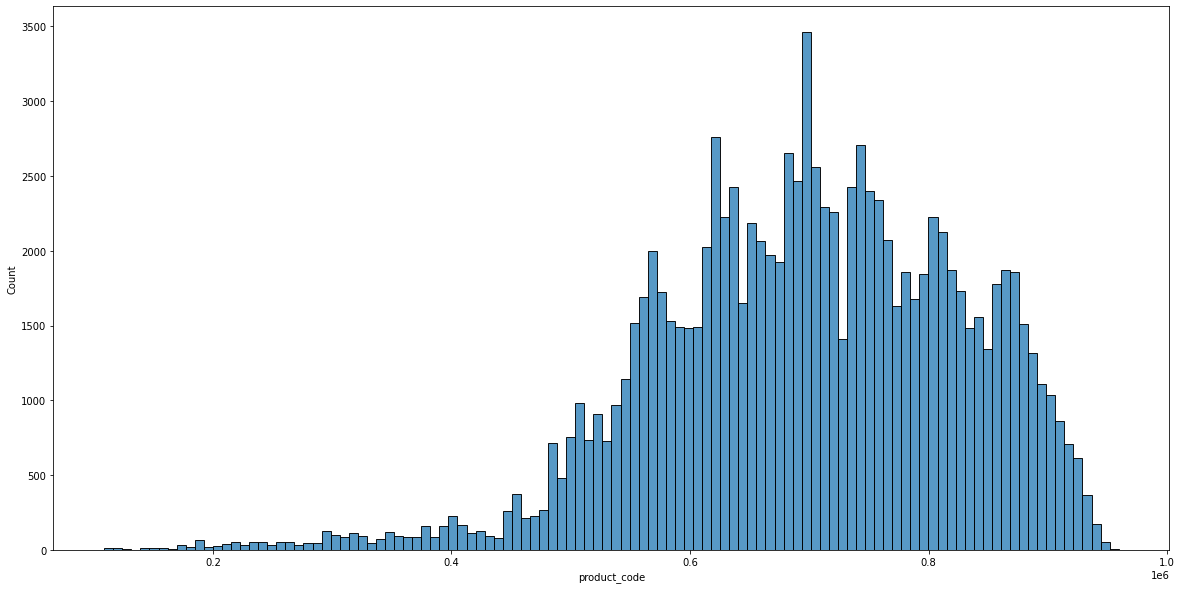

In [27]:
fig = plt.figure(figsize=(20,10))
fig =sns.histplot(articles["product_code"])

### prod_name

Productname

In [28]:
articles["prod_name"].head()

0            Strap top
1            Strap top
2        Strap top (1)
3    OP T-shirt (Idro)
4    OP T-shirt (Idro)
Name: prod_name, dtype: object

In [29]:
articles["prod_name"].nunique()

45875

## product_type_no

132 categorized product types by number. Contains -1 = unknown = NaN? = 121 

In [30]:
articles["product_type_no"].head()

0    253
1    253
2    253
3    306
4    306
Name: product_type_no, dtype: int64

In [31]:
articles["product_type_no"].nunique()

132

In [32]:
articles["product_type_no"].unique()

array([253, 306, 304, 302, 273, 252, 254, 272,  72, 532, 295, 256,  73,
        -1, 308, 196,  74,  67,  87, 298,  59, 286,  57, 275, 255, 265,
        75, 307, 274, 259,  69, 297,  94,  81, 245,  71,  70,  66, 264,
        89, 267,  91, 262,  83, 277, 305,  80, 263,  78, 257,  93, 293,
       495, 515,  76, 260,  77,  86,  82, 296, 509,  68, 258, 271,  85,
       283, 496, 161,  49, 268, 276,  84, 299,  60, 144, 270,  79, 156,
        95, 287, 261,  90,  88, 499, 100,  98,  92, 289,  96, 155, 512,
       284, 291, 285, 288, 300, 303, 349, 511, 475, 477, 351, 467, 508,
       503, 465, 230, 504, 476, 326, 494, 514, 498, 525, 231, 492, 489,
       470, 102, 366, 493, 762, 529, 464, 389, 761, 468, 521, 510, 523,
       491, 483])

In [33]:
round(articles["product_type_no"].describe(),0)

count    105542.0
mean        235.0
std          75.0
min          -1.0
25%         252.0
50%         259.0
75%         272.0
max         762.0
Name: product_type_no, dtype: float64

In [34]:
articles[articles["product_type_no"]==-1].count()

article_id                      121
product_code                    121
prod_name                       121
product_type_no                 121
product_type_name               121
product_group_name              121
graphical_appearance_no         121
graphical_appearance_name       121
colour_group_code               121
colour_group_name               121
perceived_colour_value_id       121
perceived_colour_value_name     121
perceived_colour_master_id      121
perceived_colour_master_name    121
department_no                   121
department_name                 121
index_code                      121
index_name                      121
index_group_no                  121
index_group_name                121
section_no                      121
section_name                    121
garment_group_no                121
garment_group_name              121
detail_desc                     121
dtype: int64

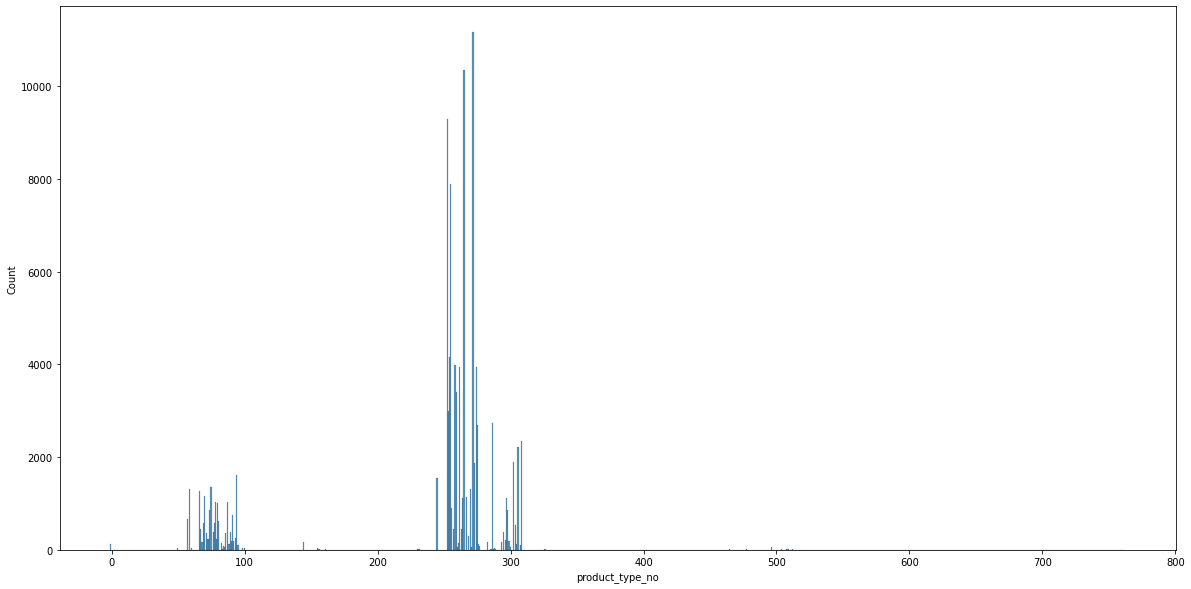

In [35]:
fig = plt.figure(figsize=(20,10))
fig = sns.histplot(articles["product_type_no"])

### product_type_name

Labels the product type

In [36]:
articles["product_type_name"].head()

0    Vest top
1    Vest top
2    Vest top
3         Bra
4         Bra
Name: product_type_name, dtype: object

In [37]:
articles["product_type_name"].nunique()

131

In [38]:
articles["product_type_name"].unique()

array(['Vest top', 'Bra', 'Underwear Tights', 'Socks', 'Leggings/Tights',
       'Sweater', 'Top', 'Trousers', 'Hair clip', 'Umbrella',
       'Pyjama jumpsuit/playsuit', 'Bodysuit', 'Hair string', 'Unknown',
       'Hoodie', 'Sleep Bag', 'Hair/alice band', 'Belt', 'Boots',
       'Bikini top', 'Swimwear bottom', 'Underwear bottom', 'Swimsuit',
       'Skirt', 'T-shirt', 'Dress', 'Hat/beanie', 'Kids Underwear top',
       'Shorts', 'Shirt', 'Cap/peaked', 'Pyjama set', 'Sneakers',
       'Sunglasses', 'Cardigan', 'Gloves', 'Earring', 'Bag', 'Blazer',
       'Other shoe', 'Jumpsuit/Playsuit', 'Sandals', 'Jacket', 'Costumes',
       'Robe', 'Scarf', 'Coat', 'Other accessories', 'Polo shirt',
       'Slippers', 'Night gown', 'Alice band', 'Straw hat', 'Hat/brim',
       'Tailored Waistcoat', 'Necklace', 'Ballerinas', 'Tie',
       'Pyjama bottom', 'Felt hat', 'Bracelet', 'Blouse',
       'Outdoor overall', 'Watch', 'Underwear body', 'Beanie', 'Giftbox',
       'Sleeping sack', 'Dungarees',

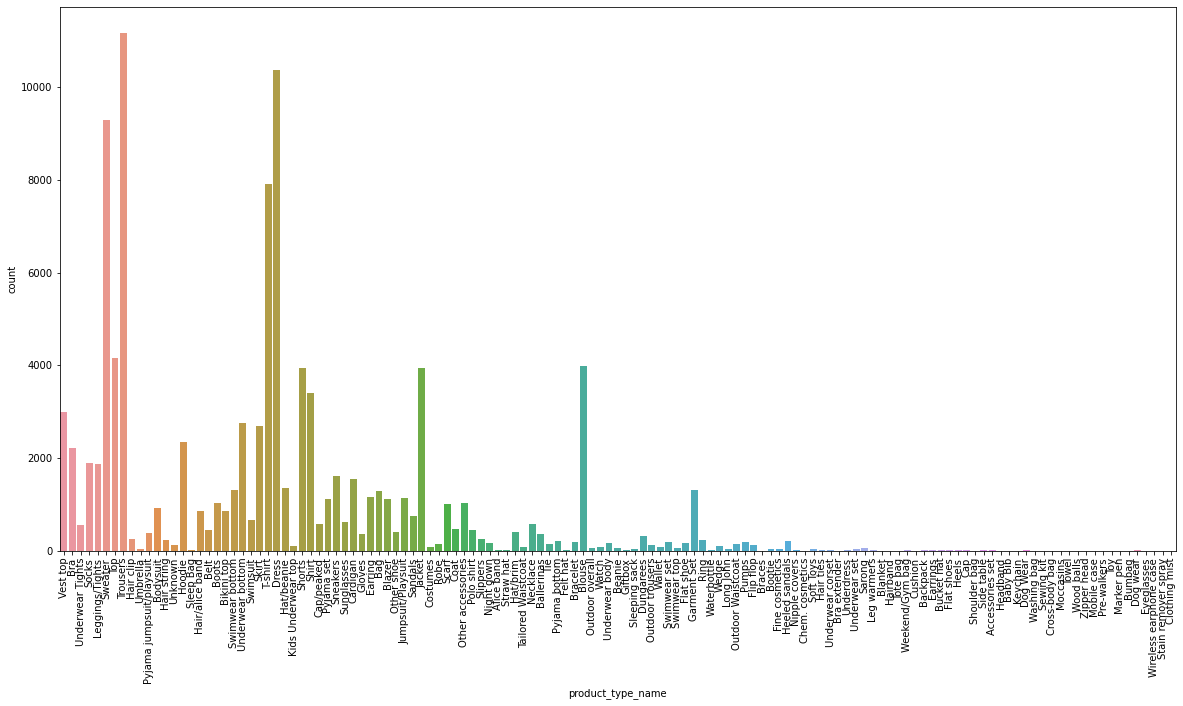

In [39]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["product_type_name"])

131 but 132 numbers ? 

### product_group_name

Product typ categories by name

In [40]:
articles["product_group_name"].head()

0    Garment Upper body
1    Garment Upper body
2    Garment Upper body
3             Underwear
4             Underwear
Name: product_group_name, dtype: object

In [41]:
articles["product_group_name"].nunique()

19

In [42]:
articles["product_group_name"].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [43]:
articles[articles["product_group_name"]=="Unknown"].count()

article_id                      121
product_code                    121
prod_name                       121
product_type_no                 121
product_type_name               121
product_group_name              121
graphical_appearance_no         121
graphical_appearance_name       121
colour_group_code               121
colour_group_name               121
perceived_colour_value_id       121
perceived_colour_value_name     121
perceived_colour_master_id      121
perceived_colour_master_name    121
department_no                   121
department_name                 121
index_code                      121
index_name                      121
index_group_no                  121
index_group_name                121
section_no                      121
section_name                    121
garment_group_no                121
garment_group_name              121
detail_desc                     121
dtype: int64

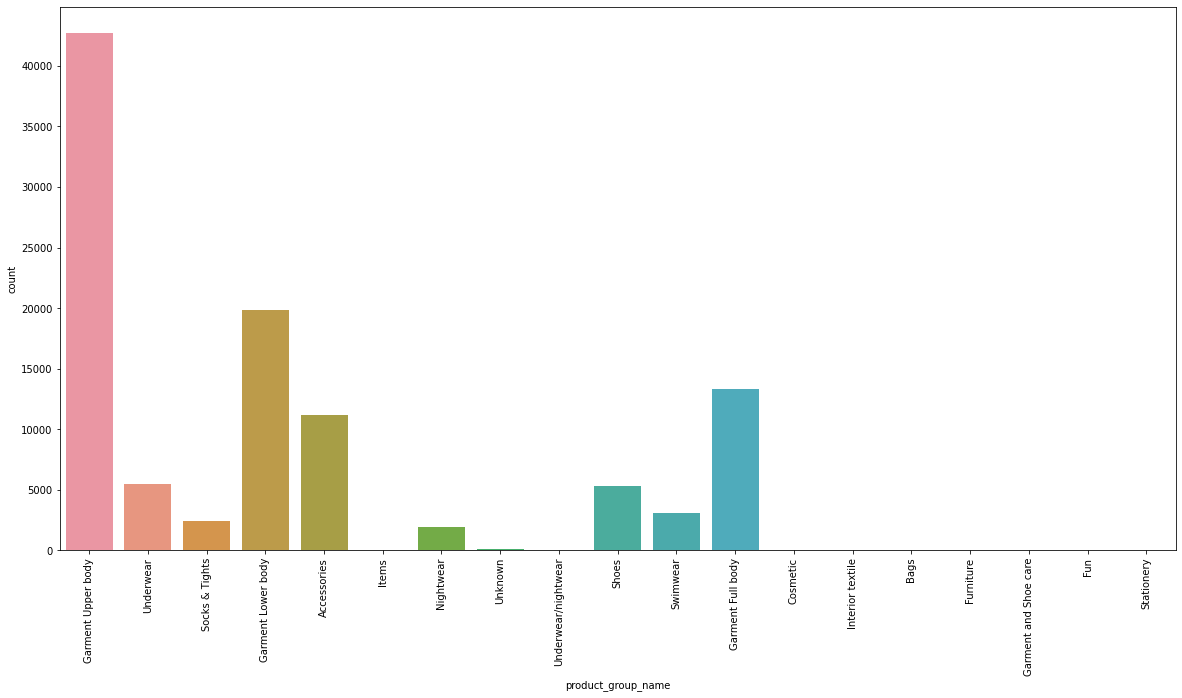

In [44]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["product_group_name"])

### graphical_appearance_no

Classification of the graphical appearence. Contains -1 = Unknown = NaN ? = 52

In [45]:
articles["graphical_appearance_no"].head()

0    1010016
1    1010016
2    1010017
3    1010016
4    1010016
Name: graphical_appearance_no, dtype: int64

In [46]:
articles["graphical_appearance_no"].nunique()

30

In [47]:
articles["graphical_appearance_no"].unique()

array([1010016, 1010017, 1010001, 1010010, 1010019, 1010011, 1010002,
       1010023, 1010005, 1010006, 1010026, 1010020, 1010018, 1010004,
       1010024, 1010008, 1010009, 1010012, 1010014, 1010013, 1010027,
       1010007, 1010021, 1010022,      -1, 1010003, 1010025, 1010028,
       1010015, 1010029])

In [48]:
round(articles["graphical_appearance_no"].describe(),0)

count     105542.0
mean     1009515.0
std        22414.0
min           -1.0
25%      1010008.0
50%      1010016.0
75%      1010016.0
max      1010029.0
Name: graphical_appearance_no, dtype: float64

In [49]:
articles[articles["graphical_appearance_no"]==-1].count()

article_id                      52
product_code                    52
prod_name                       52
product_type_no                 52
product_type_name               52
product_group_name              52
graphical_appearance_no         52
graphical_appearance_name       52
colour_group_code               52
colour_group_name               52
perceived_colour_value_id       52
perceived_colour_value_name     52
perceived_colour_master_id      52
perceived_colour_master_name    52
department_no                   52
department_name                 52
index_code                      52
index_name                      52
index_group_no                  52
index_group_name                52
section_no                      52
section_name                    52
garment_group_no                52
garment_group_name              52
detail_desc                     52
dtype: int64

In [50]:
#fig = plt.figure(figsize=(20,10))
#fig = sns.histplot(articles["graphical_appearance_no"])

### graphical_appearance_name

Label of the grapical appearance. 

In [51]:
articles["graphical_appearance_name"].head()

0     Solid
1     Solid
2    Stripe
3     Solid
4     Solid
Name: graphical_appearance_name, dtype: object

In [52]:
articles["graphical_appearance_name"].nunique()

30

In [53]:
articles["graphical_appearance_name"].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

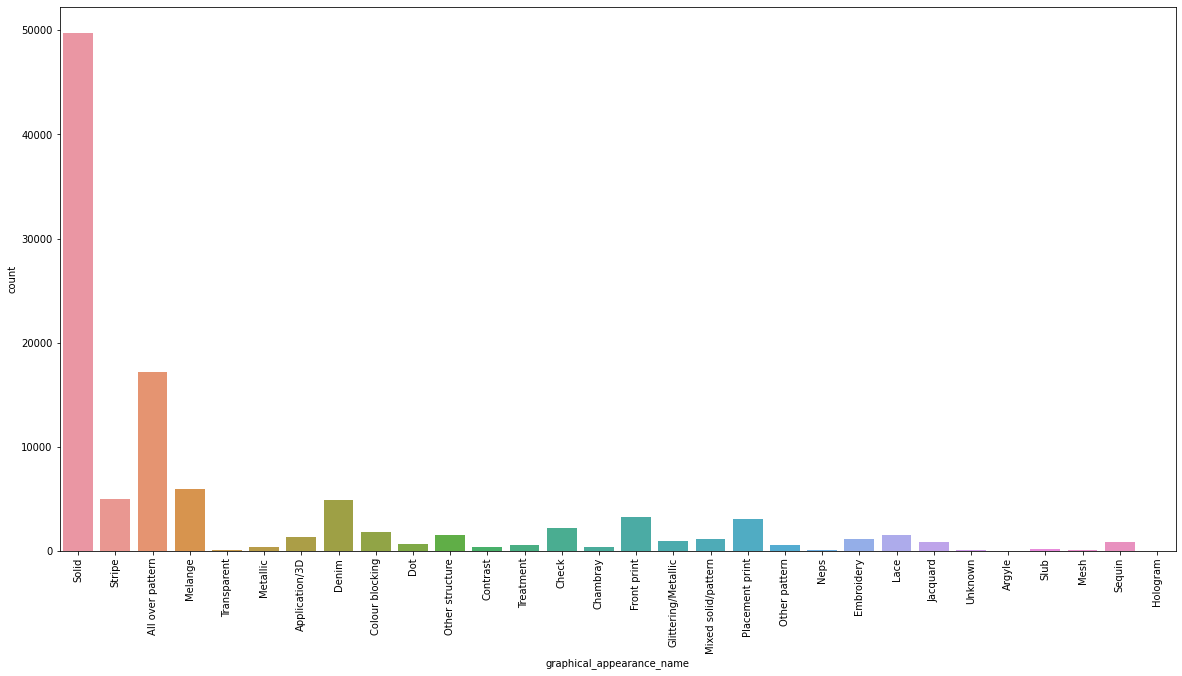

In [54]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["graphical_appearance_name"])

### colour_group_code

Categorize the colour group

In [55]:
articles["colour_group_code"].head()

0     9
1    10
2    11
3     9
4    10
Name: colour_group_code, dtype: int64

In [56]:
articles["colour_group_code"].nunique()

50

In [57]:
articles["colour_group_code"].unique()

array([ 9, 10, 11, 12, 13,  7, 71,  6, 73,  8, 52, 43, 15, 31,  3,  5, 51,
       53, 17, 72, 81, 22, 19, 23, 50, 63, 42,  2, 93, 40, 82, 33,  1, 32,
       14, 20, 91, 30, 62, 41, 21, 92, 61, 83, 60,  4, 80, 90, 70, -1])

In [58]:
articles[articles["colour_group_code"]==-1].count()

article_id                      28
product_code                    28
prod_name                       28
product_type_no                 28
product_type_name               28
product_group_name              28
graphical_appearance_no         28
graphical_appearance_name       28
colour_group_code               28
colour_group_name               28
perceived_colour_value_id       28
perceived_colour_value_name     28
perceived_colour_master_id      28
perceived_colour_master_name    28
department_no                   28
department_name                 28
index_code                      28
index_name                      28
index_group_no                  28
index_group_name                28
section_no                      28
section_name                    28
garment_group_no                28
garment_group_name              28
detail_desc                     28
dtype: int64

In [59]:
round(articles["colour_group_code"].describe(),0)

count    105542.0
mean         32.0
std          28.0
min          -1.0
25%           9.0
50%          14.0
75%          52.0
max          93.0
Name: colour_group_code, dtype: float64

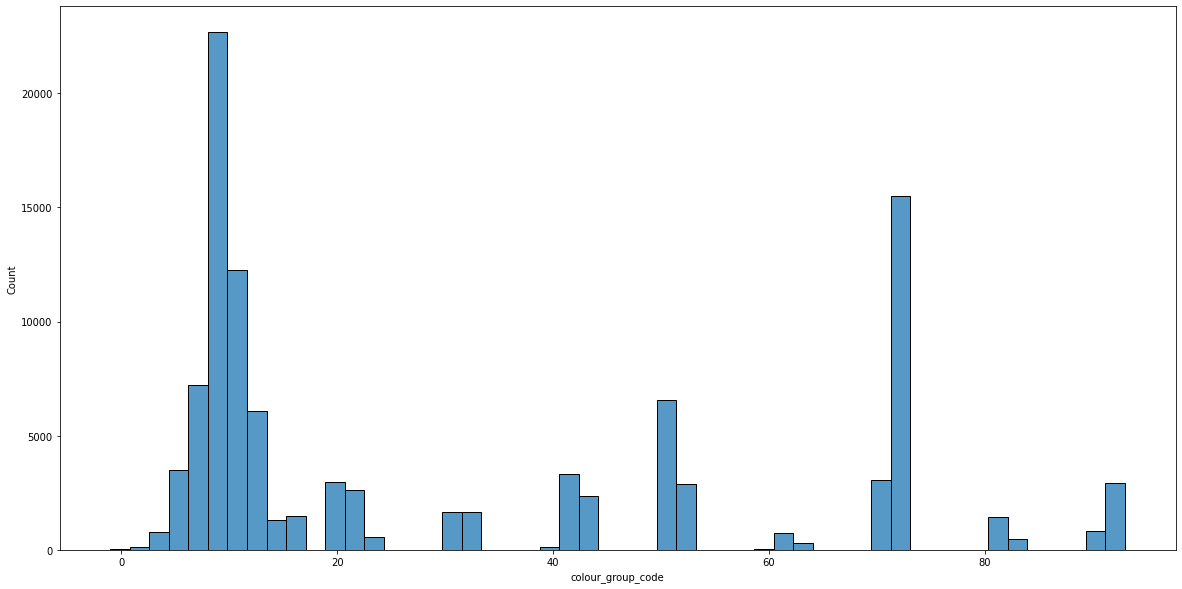

In [60]:
fig = plt.figure(figsize=(20,10))
fig=sns.histplot(articles["colour_group_code"])

### colour_group_name

Labels the group name

In [61]:
articles["colour_group_name"].head()

0        Black
1        White
2    Off White
3        Black
4        White
Name: colour_group_name, dtype: object

In [62]:
articles["colour_group_name"].nunique()

50

In [63]:
articles["colour_group_name"].unique()

array(['Black', 'White', 'Off White', 'Light Beige', 'Beige', 'Grey',
       'Light Blue', 'Light Grey', 'Dark Blue', 'Dark Grey', 'Pink',
       'Dark Red', 'Greyish Beige', 'Light Orange', 'Silver', 'Gold',
       'Light Pink', 'Dark Pink', 'Yellowish Brown', 'Blue',
       'Light Turquoise', 'Yellow', 'Greenish Khaki', 'Dark Yellow',
       'Other Pink', 'Dark Purple', 'Red', 'Transparent', 'Dark Green',
       'Other Red', 'Turquoise', 'Dark Orange', 'Other', 'Orange',
       'Dark Beige', 'Other Yellow', 'Light Green', 'Other Orange',
       'Purple', 'Light Red', 'Light Yellow', 'Green', 'Light Purple',
       'Dark Turquoise', 'Other Purple', 'Bronze/Copper',
       'Other Turquoise', 'Other Green', 'Other Blue', 'Unknown'],
      dtype=object)

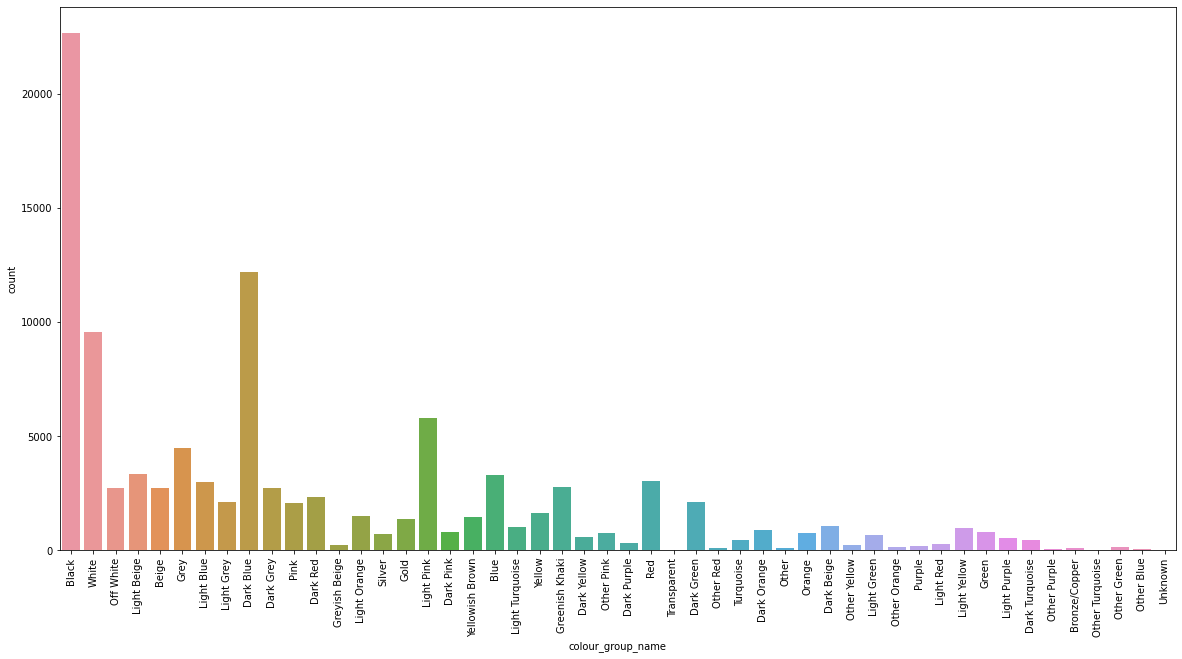

In [64]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["colour_group_name"])

### perceived_colour_value_id

Categorizes the perceived colour values aka Lightness, grey scale of the image

In [65]:
articles["perceived_colour_value_id"].head()

0    4
1    3
2    1
3    4
4    3
Name: perceived_colour_value_id, dtype: int64

In [66]:
articles["perceived_colour_value_id"].nunique()

8

In [67]:
articles["perceived_colour_value_id"].unique()

array([ 4,  3,  1,  2,  5,  7,  6, -1])

In [68]:
articles[articles["perceived_colour_value_id"]==-1].count()

article_id                      28
product_code                    28
prod_name                       28
product_type_no                 28
product_type_name               28
product_group_name              28
graphical_appearance_no         28
graphical_appearance_name       28
colour_group_code               28
colour_group_name               28
perceived_colour_value_id       28
perceived_colour_value_name     28
perceived_colour_master_id      28
perceived_colour_master_name    28
department_no                   28
department_name                 28
index_code                      28
index_name                      28
index_group_no                  28
index_group_name                28
section_no                      28
section_name                    28
garment_group_no                28
garment_group_name              28
detail_desc                     28
dtype: int64

In [69]:
round(articles["perceived_colour_value_id"].describe(),1)

count    105542.0
mean          3.2
std           1.6
min          -1.0
25%           2.0
50%           4.0
75%           4.0
max           7.0
Name: perceived_colour_value_id, dtype: float64

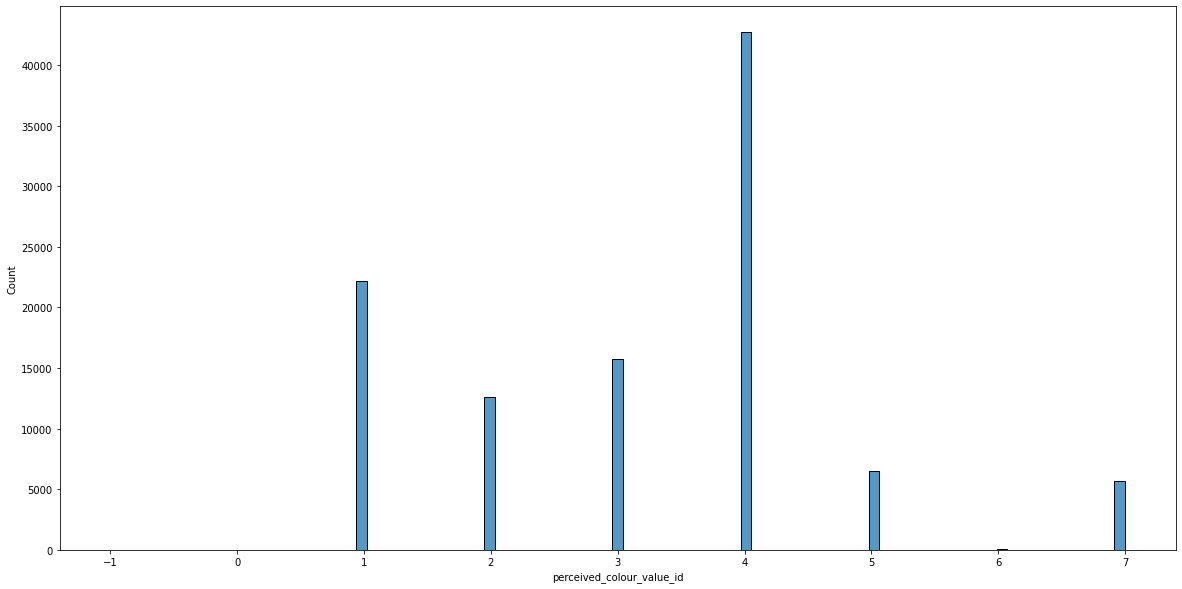

In [70]:
fig=plt.figure(figsize=(20,10))
fig= sns.histplot(articles["perceived_colour_value_id"])

### perceived_colour_value_name

Label for the perceived colour values

In [71]:
articles["perceived_colour_value_name"].head()

0           Dark
1          Light
2    Dusty Light
3           Dark
4          Light
Name: perceived_colour_value_name, dtype: object

In [72]:
articles["perceived_colour_value_name"].nunique()

8

In [73]:
articles["perceived_colour_value_name"].unique()

array(['Dark', 'Light', 'Dusty Light', 'Medium Dusty', 'Bright', 'Medium',
       'Undefined', 'Unknown'], dtype=object)

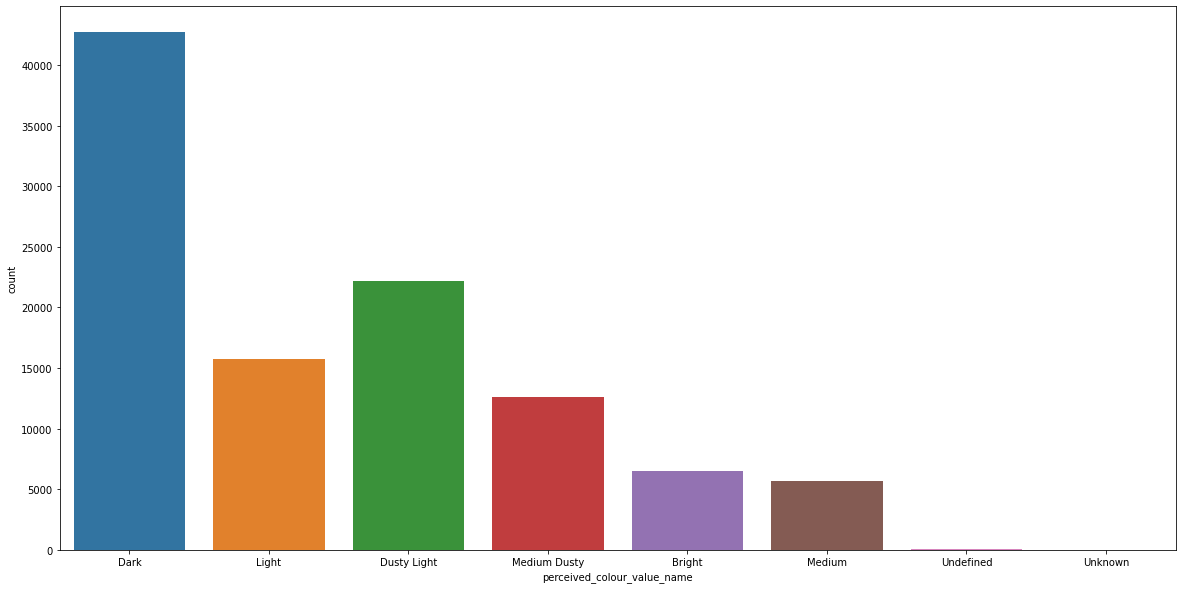

In [74]:
fig = plt.figure(figsize=(20,10))
fig= sns.countplot(articles["perceived_colour_value_name"])

### perceived_colour_master_id

In [75]:
articles["perceived_colour_master_id"].head()

0    5
1    9
2    9
3    5
4    9
Name: perceived_colour_master_id, dtype: int64

In [76]:
articles["perceived_colour_master_id"].nunique()

20

In [77]:
articles["perceived_colour_master_id"].unique()

array([ 5,  9, 11, 12,  2,  4,  6, 18,  1,  3, 15, 13,  7,  8, 20, 19, 14,
       -1, 10, 16])

In [78]:
articles[articles["perceived_colour_master_id"]==-1].count()

article_id                      685
product_code                    685
prod_name                       685
product_type_no                 685
product_type_name               685
product_group_name              685
graphical_appearance_no         685
graphical_appearance_name       685
colour_group_code               685
colour_group_name               685
perceived_colour_value_id       685
perceived_colour_value_name     685
perceived_colour_master_id      685
perceived_colour_master_name    685
department_no                   685
department_name                 685
index_code                      685
index_name                      685
index_group_no                  685
index_group_name                685
section_no                      685
section_name                    685
garment_group_no                685
garment_group_name              685
detail_desc                     684
dtype: int64

In [79]:
round(articles["perceived_colour_master_id"].describe(),1)

count    105542.0
mean          7.8
std           5.4
min          -1.0
25%           4.0
50%           5.0
75%          11.0
max          20.0
Name: perceived_colour_master_id, dtype: float64

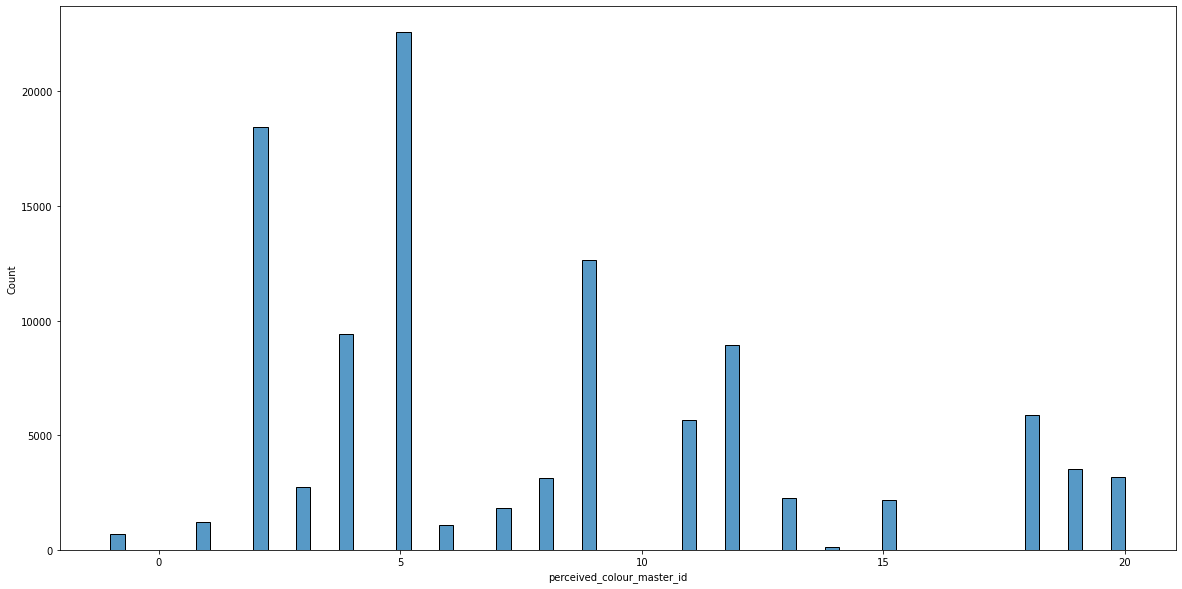

In [80]:
fig=plt.figure(figsize=(20,10))
fig=sns.histplot(articles["perceived_colour_master_id"])

### perceived_colour_master_name

Lable of the  perceived colour master 

In [81]:
articles["perceived_colour_master_name"].head()

0    Black
1    White
2    White
3    Black
4    White
Name: perceived_colour_master_name, dtype: object

In [82]:
articles["perceived_colour_master_name"].nunique()

20

In [83]:
articles["perceived_colour_master_name"].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Lilac Purple',
       'Red', 'Mole', 'Orange', 'Metal', 'Brown', 'Turquoise', 'Yellow',
       'Khaki green', 'Green', 'undefined', 'Unknown', 'Yellowish Green',
       'Bluish Green'], dtype=object)

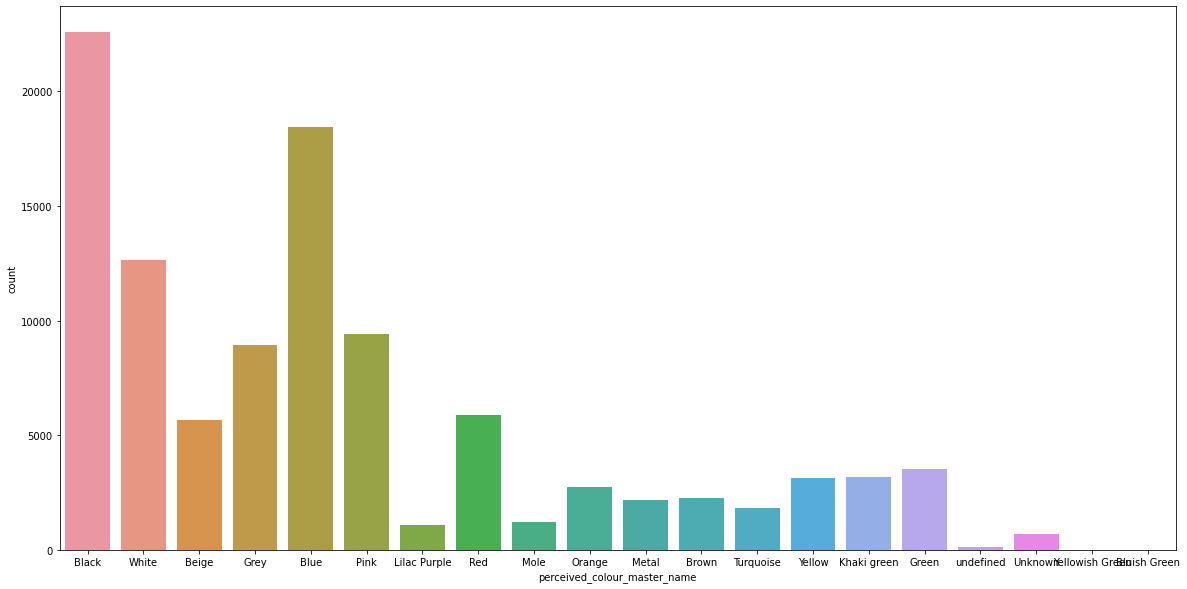

In [84]:
fig = plt.figure(figsize=(20,10))
fig= sns.countplot(articles["perceived_colour_master_name"])

### department_no

Department number ( 299 are given to 250 departmens = some departments are distributed? )

In [85]:
articles["department_no"].head()

0    1676
1    1676
2    1676
3    1339
4    1339
Name: department_no, dtype: int64

In [86]:
articles["department_no"].nunique()

299

In [87]:
articles["department_no"].unique()

array([1676, 1339, 3608, 6515, 1334, 5883, 2032, 4342, 4343, 3419, 6563,
       8559, 8394, 7956, 3611, 3610, 3937, 7930, 5283, 3509, 3929, 4242,
       7988, 1643, 5963, 8560, 7668, 7932, 5783, 3709, 5683, 3946, 8888,
       3519, 5656, 3945, 5868, 9985, 4344, 5962, 1649, 3209, 8615, 1626,
       2031, 5658, 5961, 1338, 1722, 7922, 8768, 7921, 7931, 3630, 2035,
       5882, 3629, 3710, 8558, 3948, 3944, 8756, 1919, 1939, 5960, 3705,
       7188, 1745, 1773, 1779, 5878, 7389, 5828, 1747, 1772, 1244, 8956,
       3439, 3409, 9986, 1344, 1444, 7920, 6541, 1948, 8757, 4312, 8917,
       3527, 2950, 1717, 1343, 5673, 5957, 8090, 5687, 5831, 7388, 1666,
       5631, 1920, 8616, 8617, 5731, 1949, 2033, 5672, 8718, 1201, 5884,
       5958, 1545, 1644, 5679, 6512, 5686, 3040, 5956, 1547, 6564, 1422,
       1670, 4345, 5832, 5454, 4225, 1641, 1647, 4214, 4224, 5952, 9984,
       4310, 4320, 8316, 8310, 1636, 5777, 5555, 2034, 6565, 4210, 4220,
       1414, 1723, 4314, 5848, 4317, 1543, 1510, 16

In [88]:
round(articles["department_no"].describe(),1)

count    105542.0
mean       4532.8
std        2712.7
min        1201.0
25%        1676.0
50%        4222.0
75%        7389.0
max        9989.0
Name: department_no, dtype: float64

### department_name

In [89]:
articles["department_name"].head()

0      Jersey Basic
1      Jersey Basic
2      Jersey Basic
3    Clean Lingerie
4    Clean Lingerie
Name: department_name, dtype: object

In [90]:
articles["department_name"].head()

0      Jersey Basic
1      Jersey Basic
2      Jersey Basic
3    Clean Lingerie
4    Clean Lingerie
Name: department_name, dtype: object

In [91]:
articles["department_name"].unique()

array(['Jersey Basic', 'Clean Lingerie', 'Tights basic', 'Baby basics',
       'Casual Lingerie', 'Jersey', 'EQ & Special Collections',
       'Hair Accessories', 'Other items', 'Baby Nightwear',
       'Men Sport Woven', 'Men Sport Bottoms', 'Kids Boy Denim',
       'Shopbasket Socks', 'Socks', 'UW', 'Young Girl Jersey Basic',
       'Jacket Street', 'Belts', 'Divided Shoes', 'Swimwear',
       'Underwear Jersey', 'Basic 1', 'Tops Knitwear DS', 'Men Sport Acc',
       'Kids Boy Jersey Basic', 'Young Girl UW/NW', 'Shirt', 'Nightwear',
       'Trouser', 'Small Accessories', 'Sunglasses', 'Gloves/Hats',
       'Knit & Woven', 'Basics', 'Accessories', 'Jewellery',
       'Jersey Fancy DS', 'Trousers DS', 'Bags', 'Blazer S&T', 'Knitwear',
       'Woven bottoms', 'Shorts', 'Dresses DS', 'Expressive Lingerie',
       'Kids Girl UW/NW', 'Young Boy Jersey Basic', 'Kids Girl S&T',
       'Young Girl S&T', 'Shoes / Boots inactive from s5', 'Nursing',
       'Jersey Fancy', 'Shoes', 'Functional L

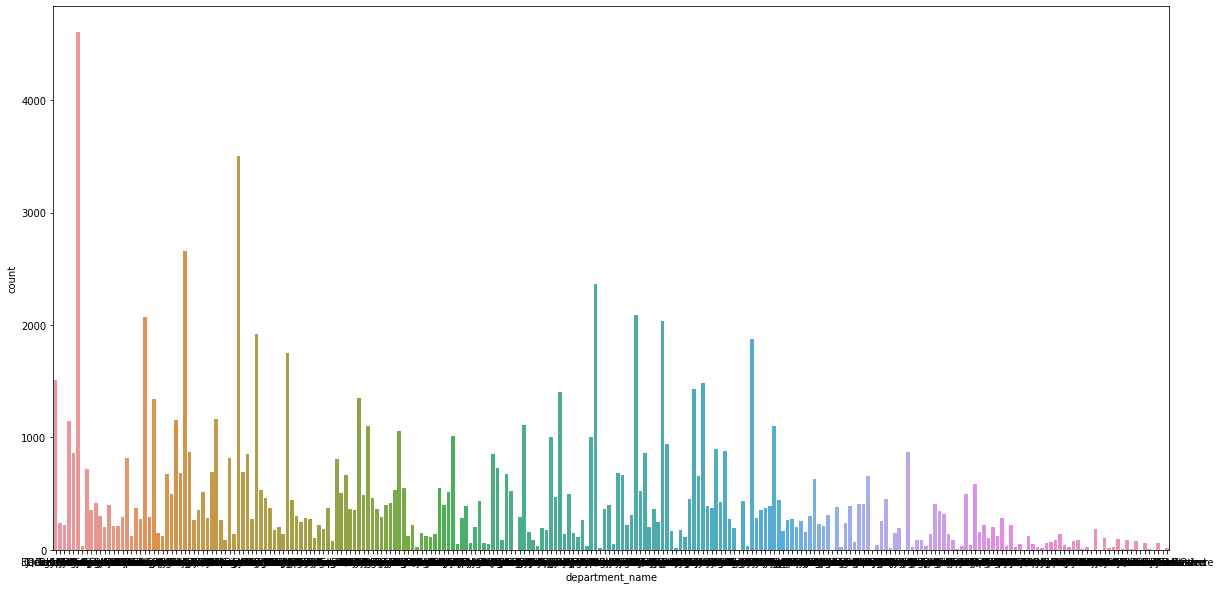

In [92]:
fig = plt.figure(figsize=(20,10))
fig= sns.countplot(articles["department_name"])

### index_code

Categorize in type and target person (gender)

In [93]:
articles["index_code"].head()

0    A
1    A
2    A
3    B
4    B
Name: index_code, dtype: object

In [94]:
articles["index_code"].nunique()

10

In [95]:
articles["index_code"].unique()

array(['A', 'B', 'G', 'F', 'C', 'S', 'H', 'D', 'I', 'J'], dtype=object)

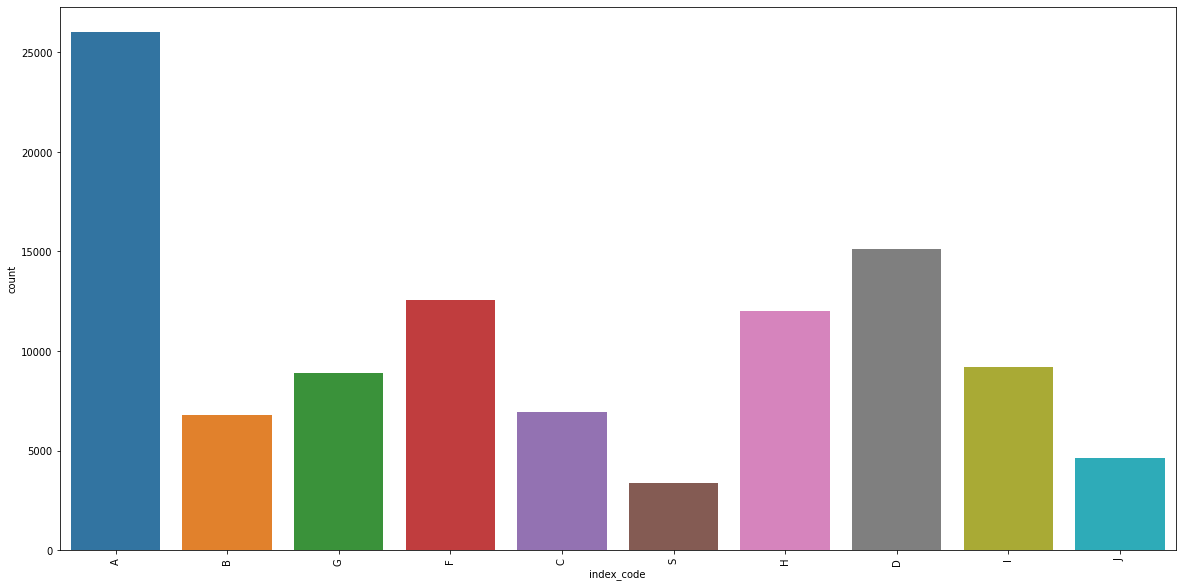

In [96]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["index_code"])

### index_name

Label of the index_name

In [97]:
articles["index_name"].head()

0          Ladieswear
1          Ladieswear
2          Ladieswear
3    Lingeries/Tights
4    Lingeries/Tights
Name: index_name, dtype: object

In [98]:
articles["index_name"].nunique()

10

In [99]:
articles["index_name"].unique()

array(['Ladieswear', 'Lingeries/Tights', 'Baby Sizes 50-98', 'Menswear',
       'Ladies Accessories', 'Sport', 'Children Sizes 92-140', 'Divided',
       'Children Sizes 134-170', 'Children Accessories, Swimwear'],
      dtype=object)

### index_group_no

Corser categorized groups

In [100]:
articles["index_group_no"].head()

0    1
1    1
2    1
3    1
4    1
Name: index_group_no, dtype: int64

In [101]:
articles["index_group_no"].nunique()

5

In [102]:
articles["index_group_no"].unique()

array([ 1,  4,  3, 26,  2])

In [103]:
round(articles["index_group_no"].describe(),1)

count    105542.0
mean          3.2
std           4.4
min           1.0
25%           1.0
50%           2.0
75%           4.0
max          26.0
Name: index_group_no, dtype: float64

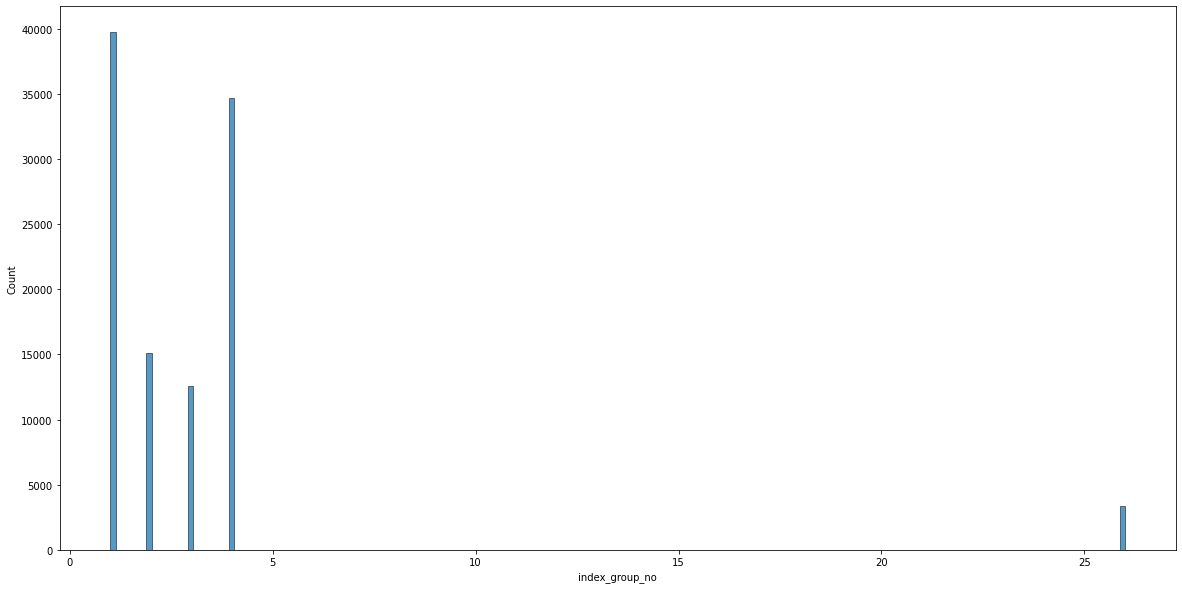

In [104]:
fig=plt.figure(figsize=(20,10))
fig=sns.histplot(articles["index_group_no"])

### index_group_name

Labeling for the index groups.

In [105]:
articles["index_group_name"].head()

0    Ladieswear
1    Ladieswear
2    Ladieswear
3    Ladieswear
4    Ladieswear
Name: index_group_name, dtype: object

In [106]:
articles["index_group_name"].nunique()

5

In [107]:
articles["index_group_name"].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

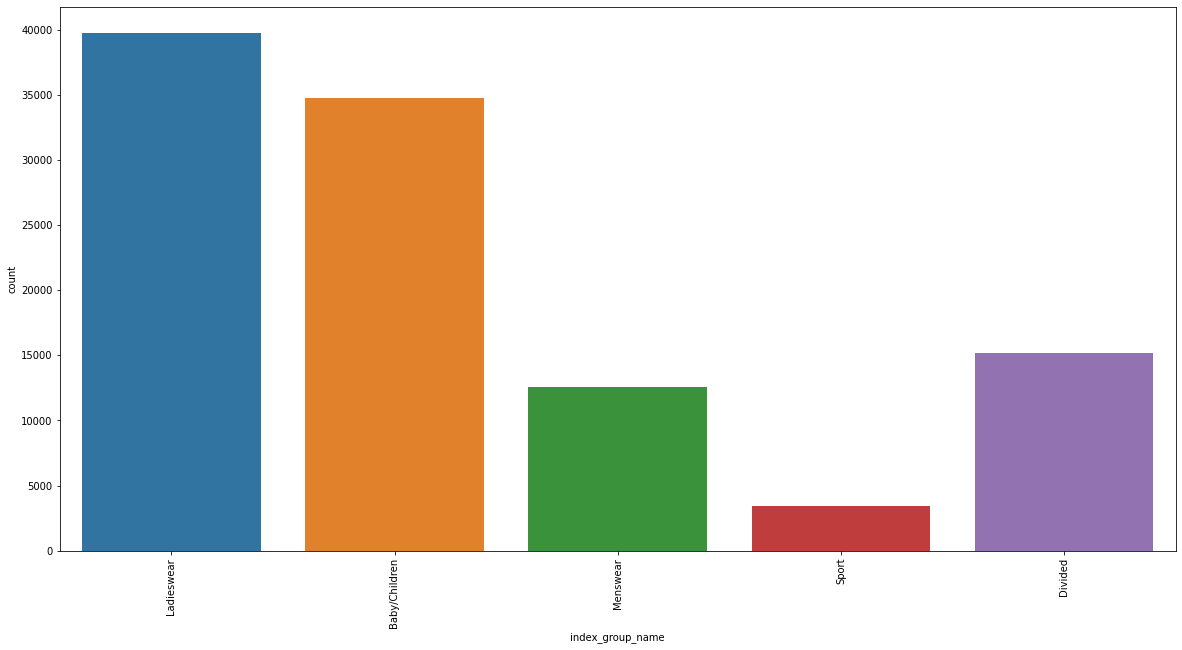

In [108]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["index_group_name"])

they are not sorted! 

### section_no

Categoizsatio by a finer categorization of the clothes and targed customer

In [109]:
articles["section_no"].head()

0    16
1    16
2    16
3    61
4    61
Name: section_no, dtype: int64

In [110]:
articles["section_no"].nunique()

57

In [111]:
articles["section_no"].unique()

array([16, 61, 62, 44, 26,  8, 66, 22, 46, 51, 79, 31, 65, 52, 60, 58, 72,
       55, 21, 25, 23, 15, 27, 47,  2, 53, 57, 20, 18, 45, 77, 64, 11, 50,
       56, 29, 19, 30, 41,  6, 43,  5, 42, 40, 76, 80, 14, 82, 49, 24, 28,
       97, 70, 71, 48,  4, 17])

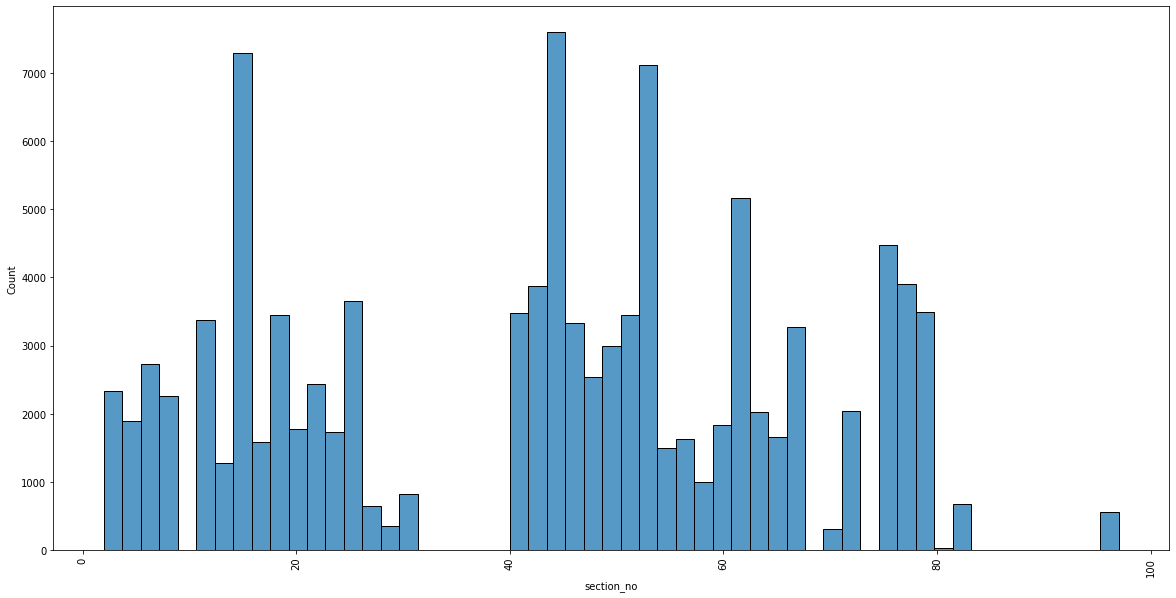

In [112]:
fig=plt.figure(figsize=(20,10))
#plt.xticks(arange(2))
fig =plt.xticks(rotation=90)
fig=sns.histplot(articles["section_no"])

### section_name

Labeling of the sections

In [113]:
articles["section_name"].head()

0    Womens Everyday Basics
1    Womens Everyday Basics
2    Womens Everyday Basics
3           Womens Lingerie
4           Womens Lingerie
Name: section_name, dtype: object

In [114]:
articles["section_name"].nunique()

56

In [115]:
articles["section_name"].unique()

array(['Womens Everyday Basics', 'Womens Lingerie',
       'Womens Nightwear, Socks & Tigh', 'Baby Essentials & Complements',
       'Men Underwear', 'Mama', 'Womens Small accessories',
       'Men H&M Sport', 'Kids Boy', 'Divided Basics',
       'Girls Underwear & Basics', 'Mens Outerwear',
       'Womens Big accessories', 'Divided Accessories',
       'Womens Swimwear, beachwear', 'Divided Selected',
       'Boys Underwear & Basics', 'Contemporary Street',
       'Contemporary Casual', 'Men Accessories', 'Men Suits & Tailoring',
       'Womens Everyday Collection', 'Men Shoes', 'Young Boy', 'H&M+',
       'Divided Collection', 'Ladies Denim', 'Contemporary Smart',
       'Womens Trend', 'Kids Outerwear', 'Young Girl', 'Womens Shoes',
       'Womens Tailoring', 'Divided Projects', 'Denim Men', 'Men Other',
       'Womens Jackets', 'Men Other 2', 'Baby Boy', 'Womens Casual',
       'Kids Accessories, Swimwear & D', 'Ladies H&M Sport',
       'Kids & Baby Shoes', 'Baby Girl', 'Kids Girl

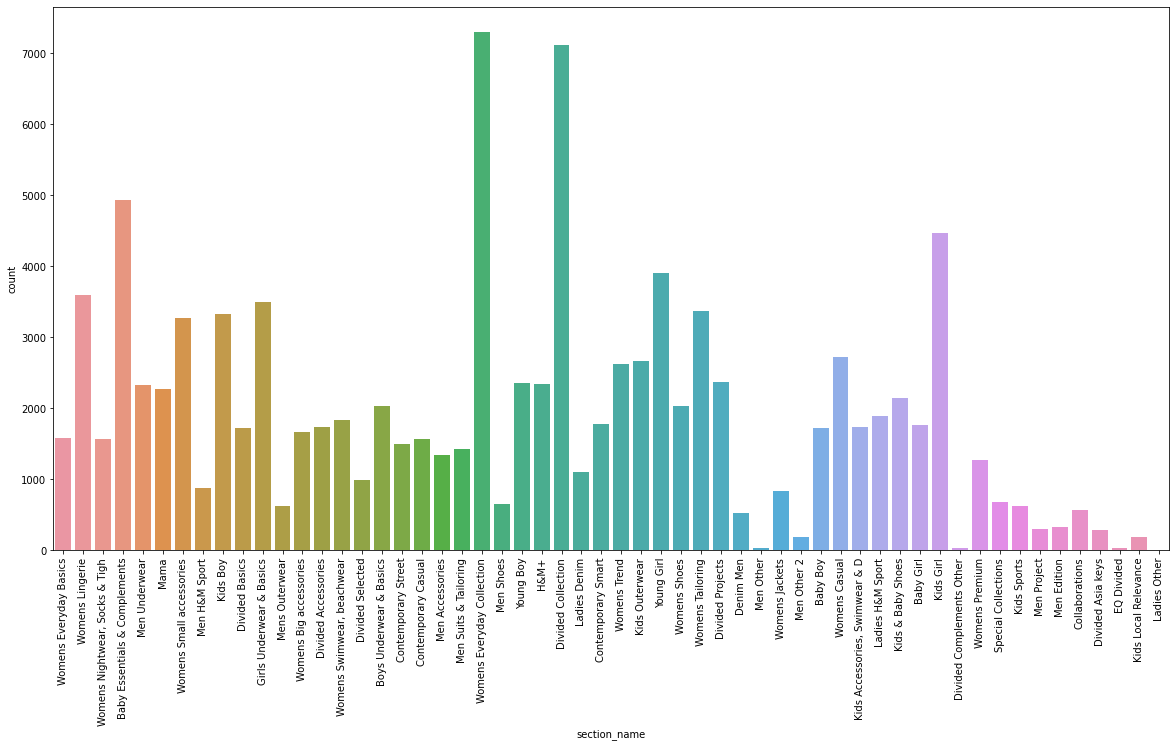

In [116]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["section_name"])

### garment_group_no

Categorization for garnets 

In [117]:
articles["garment_group_no"].head()

0    1002
1    1002
2    1002
3    1017
4    1017
Name: garment_group_no, dtype: int64

In [118]:
articles["garment_group_no"].nunique()

21

In [119]:
articles["garment_group_no"].unique()

array([1002, 1017, 1021, 1005, 1019, 1016, 1007, 1020, 1018, 1003, 1011,
       1009, 1008, 1025, 1013, 1012, 1023, 1010, 1001, 1006, 1014])

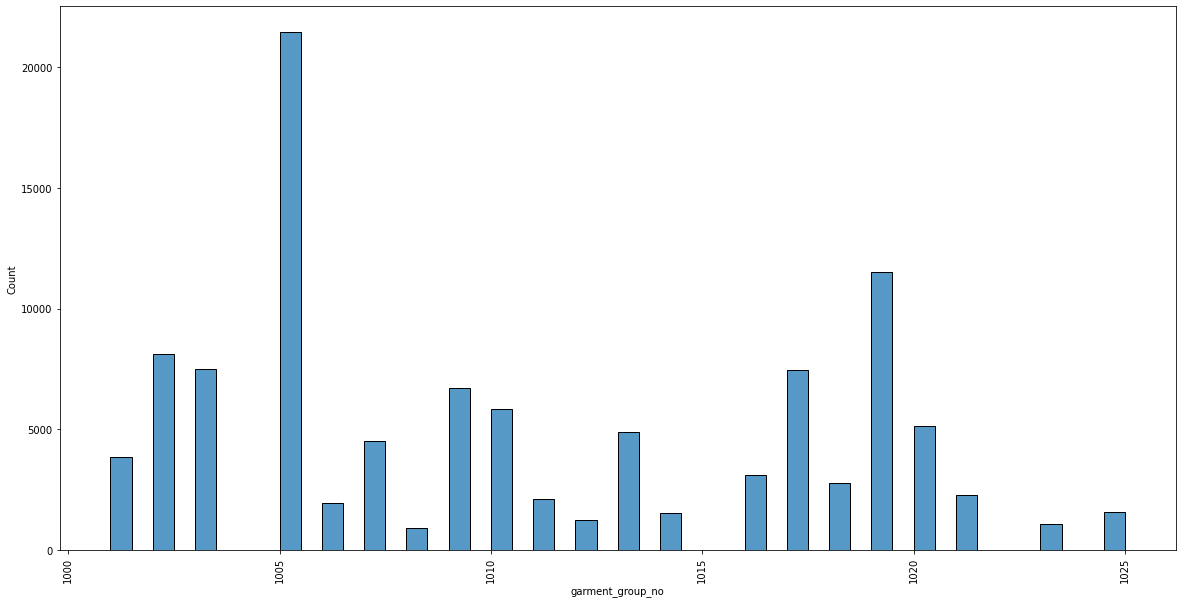

In [120]:
fig=plt.figure(figsize=(20,10))
#plt.xticks(arange(2))
fig =plt.xticks(rotation=90)
fig=sns.histplot(articles["garment_group_no"])

### garment_group_name

Labeling of the garment groups

In [121]:
articles["garment_group_name"].head()

0         Jersey Basic
1         Jersey Basic
2         Jersey Basic
3    Under-, Nightwear
4    Under-, Nightwear
Name: garment_group_name, dtype: object

In [122]:
articles["garment_group_name"].nunique()

21

In [123]:
articles["garment_group_name"].unique()

array(['Jersey Basic', 'Under-, Nightwear', 'Socks and Tights',
       'Jersey Fancy', 'Accessories', 'Trousers Denim', 'Outdoor',
       'Shoes', 'Swimwear', 'Knitwear', 'Shirts', 'Trousers', 'Dressed',
       'Shorts', 'Dresses Ladies', 'Skirts', 'Special Offers', 'Blouses',
       'Unknown', 'Woven/Jersey/Knitted mix Baby', 'Dresses/Skirts girls'],
      dtype=object)

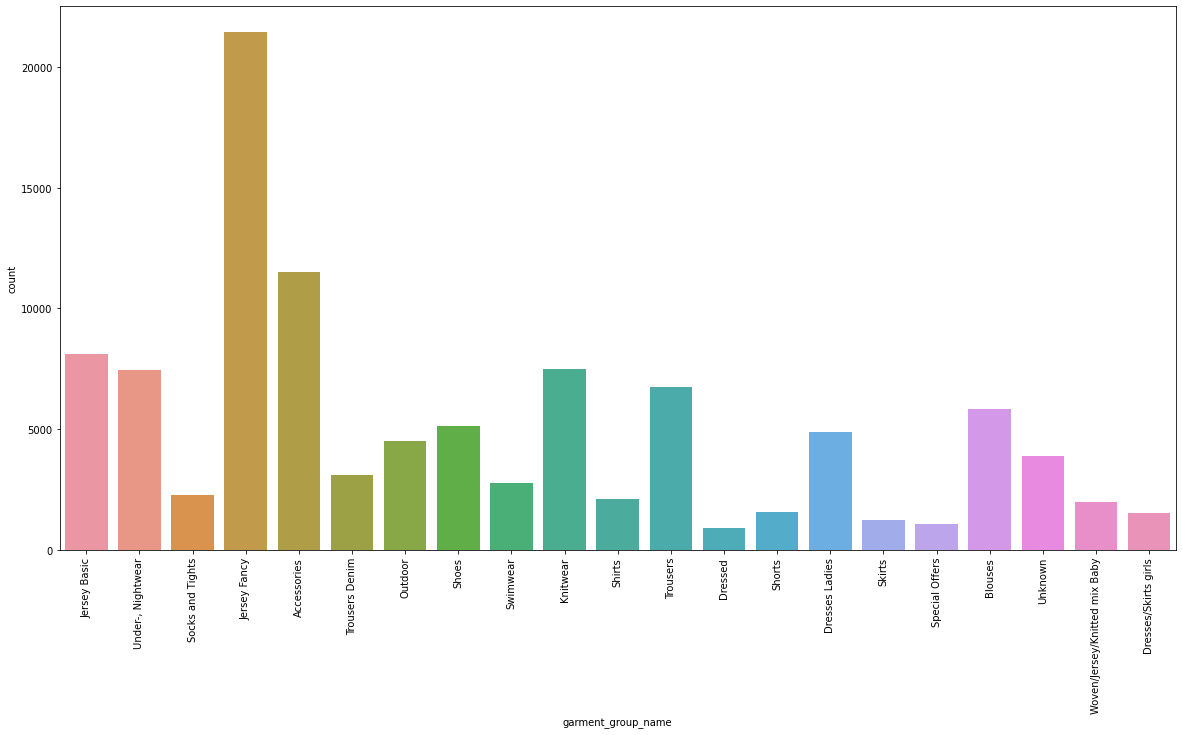

In [124]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(articles["garment_group_name"])

### detail_desc

Detailed description of the articles (groups)

In [125]:
articles["detail_desc"].head()

0              Jersey top with narrow shoulder straps.
1              Jersey top with narrow shoulder straps.
2              Jersey top with narrow shoulder straps.
3    Microfibre T-shirt bra with underwired, moulde...
4    Microfibre T-shirt bra with underwired, moulde...
Name: detail_desc, dtype: object

In [126]:
articles["detail_desc"].nunique()

43404

In [127]:
articles["detail_desc"].isnull().sum()

416

In [128]:
articles[articles["detail_desc"].isnull()]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
1467,351332007,351332,Marshall Lace up Top,252,Sweater,Garment Upper body,1010018,Treatment,7,Grey,...,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,NaN
2644,420049002,420049,OL TAGE PQ,87,Boots,Shoes,1010016,Solid,13,Beige,...,Premium Quality,C,Ladies Accessories,1,Ladieswear,64,Womens Shoes,1020,Shoes,NaN
2645,420049003,420049,OL TAGE PQ,87,Boots,Shoes,1010016,Solid,23,Dark Yellow,...,Premium Quality,C,Ladies Accessories,1,Ladieswear,64,Womens Shoes,1020,Shoes,NaN
2742,426199002,426199,Ellen Shortie Daisy Low 3p,286,Underwear bottom,Underwear,1010016,Solid,9,Black,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",NaN
2743,426199010,426199,Ellen Shortie Daisy Low 3p,286,Underwear bottom,Underwear,1010017,Stripe,8,Dark Grey,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67838,752458001,752458,Poissy boho dress,265,Dress,Garment Full body,1010007,Embroidery,10,White,...,Dress,A,Ladieswear,1,Ladieswear,6,Womens Casual,1013,Dresses Ladies,NaN
72720,768842001,768842,Andrews set,270,Garment Set,Garment Full body,1010017,Stripe,10,White,...,Baby Boy Woven,G,Baby Sizes 50-98,4,Baby/Children,41,Baby Boy,1006,Woven/Jersey/Knitted mix Baby,NaN
72721,768842004,768842,Andrews set,270,Garment Set,Garment Full body,1010004,Check,73,Dark Blue,...,Baby Boy Woven,G,Baby Sizes 50-98,4,Baby/Children,41,Baby Boy,1006,Woven/Jersey/Knitted mix Baby,NaN
93144,856985001,856985,Pogo rope,67,Belt,Accessories,1010016,Solid,12,Light Beige,...,Belts,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,NaN


## Customer 

### General description of the customers.csv

In [129]:
custom.shape

(1371980, 7)

In [130]:
custom.size

9603860

In [131]:
custom.memory_usage(index=True, deep=True).sum()/1e+6

537.182992

In [132]:
custom.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

In [133]:
custom.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [134]:
custom.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 512.3 MB


In [135]:
round(custom.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
FN,476930.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
Active,464404.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
age,1356119.0,36.39,14.31,16.0,24.0,32.0,49.0,99.0


In [136]:
round(custom.describe(include=np.object).T,2)

,count,unique,top,freq
customer_id,1371980,1371980,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1
club_member_status,1365918,3,ACTIVE,1272491
fashion_news_frequency,1355971,4,NONE,877711
postal_code,1371980,352899,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303


In [137]:
custom.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

In [138]:
custom.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

## Columns description

|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
|[customer_id](#customerid) |	object|	Custumer id|	1371980| hashed Customer Id|
|[FN](#fn)	|float64	|Recievs Fashion News|	1|
|[Active](#active) |	float64	|customer is active for communication|	1| Active = ACTIVE $\downarrow$|
|[club_member_status](#clubmemberstatus)	|object|	club status |	3| ACTIVE = Active ? $\uparrow$|
|[fashion_news_frequency](#fashionnewsfrequency)|	object	|Fashion News frequency	|4| interested in topics |
|[age](#age())	|float64|	age |	84| |
|[postal_code](#postalcode) |object|	Zip code |	352899| Hashed postalcode|

### customer_id

In [139]:
custom["customer_id"].head()

0    00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1    0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2    000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3    00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4    00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
Name: customer_id, dtype: object

In [140]:
custom["customer_id"].nunique()

1371980

### FN

Recievs Fashion News (FN)

In [141]:
custom["FN"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    1.0
Name: FN, dtype: float64

In [142]:
custom["FN"].nunique()

1

In [143]:
custom["FN"].unique()

array([nan,  1.])

In [144]:
custom["FN"].isnull().sum()

895050

In [145]:
custom[custom["FN"].isnull()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
...,...,...,...,...,...,...,...
1371968,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,NaN,NaN,ACTIVE,NONE,40.0,3b4a300713f8b142836a67caa5b6d5b3f10a7650c06820...
1371972,ffff8f9ecdce722b5bab97fff68a6d1866492209bfe524...,NaN,NaN,ACTIVE,NONE,52.0,0de9d1ec7dc785301ca5fbe8949cfc2cfbd77e7a807270...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...


### Active

Active is if the customer is active for communication

In [146]:
custom["Active"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    1.0
Name: Active, dtype: float64

In [147]:
custom["Active"].nunique()

1

In [148]:
custom["Active"].unique()

array([nan,  1.])

In [149]:
custom["Active"].isnull().sum()

907576

In [150]:
custom[custom["Active"].isnull()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
...,...,...,...,...,...,...,...
1371968,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,NaN,NaN,ACTIVE,NONE,40.0,3b4a300713f8b142836a67caa5b6d5b3f10a7650c06820...
1371972,ffff8f9ecdce722b5bab97fff68a6d1866492209bfe524...,NaN,NaN,ACTIVE,NONE,52.0,0de9d1ec7dc785301ca5fbe8949cfc2cfbd77e7a807270...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...


### club_member_status

Gives the club memer status

In [151]:
custom["club_member_status"].head()

0    ACTIVE
1    ACTIVE
2    ACTIVE
3    ACTIVE
4    ACTIVE
Name: club_member_status, dtype: object

In [152]:
custom["club_member_status"].nunique()

3

In [153]:
custom["club_member_status"].unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [154]:
custom["club_member_status"].isnull().sum()

6062

In [155]:
custom[custom["club_member_status"].isnull()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
844,00283eca790298966c821223d7f2a33cd9ec3502aee2b4...,NaN,NaN,NaN,NONE,NaN,cd12e98fcbbbcbcc3b032efa9c377e9ec9f8459ddefcbf...
853,00286e2aaf05a86e2e6f6dc2603f036905a1601e0ee003...,NaN,NaN,NaN,NONE,52.0,e867d8b871a7bfe9861140cb3135e7bc1af9d7d1d95ed0...
908,002b19e907d63540d9176baffba80242c94859a5e97b3f...,NaN,NaN,NaN,NONE,26.0,fef5ba03d82e9cc5648c6e9659d646602d5244cdf208b0...
940,002c85ad44c3cb34c3e2c9105716840c3dc3d4e689b19a...,NaN,NaN,NaN,NONE,29.0,3720901dc3124075bd079049586d71d5bdaff8ef7e4ec1...
...,...,...,...,...,...,...,...
1370268,ffacd36a89e6042179219ae960aa8e6d95db24978384b7...,NaN,NaN,NaN,NONE,23.0,06bf2de0036c0ae68883f1c31f3dcaf037acc997e893f7...
1370365,ffb1b4a7212f1ba70007e0522a4d8671805ca7ba061f73...,NaN,NaN,NaN,NONE,17.0,2c834e07de11cc8d871f169eb156822d9869f026001751...
1370368,ffb1f4591bd4b7ba4c3da6a172a5e25079370d06194d4a...,NaN,NaN,NaN,NONE,25.0,9d575c0b5100be18d0894d8a6380db7409c54a69d101b1...
1371434,ffe528076021fe882398934647ae6c15b1044c12c693c9...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...


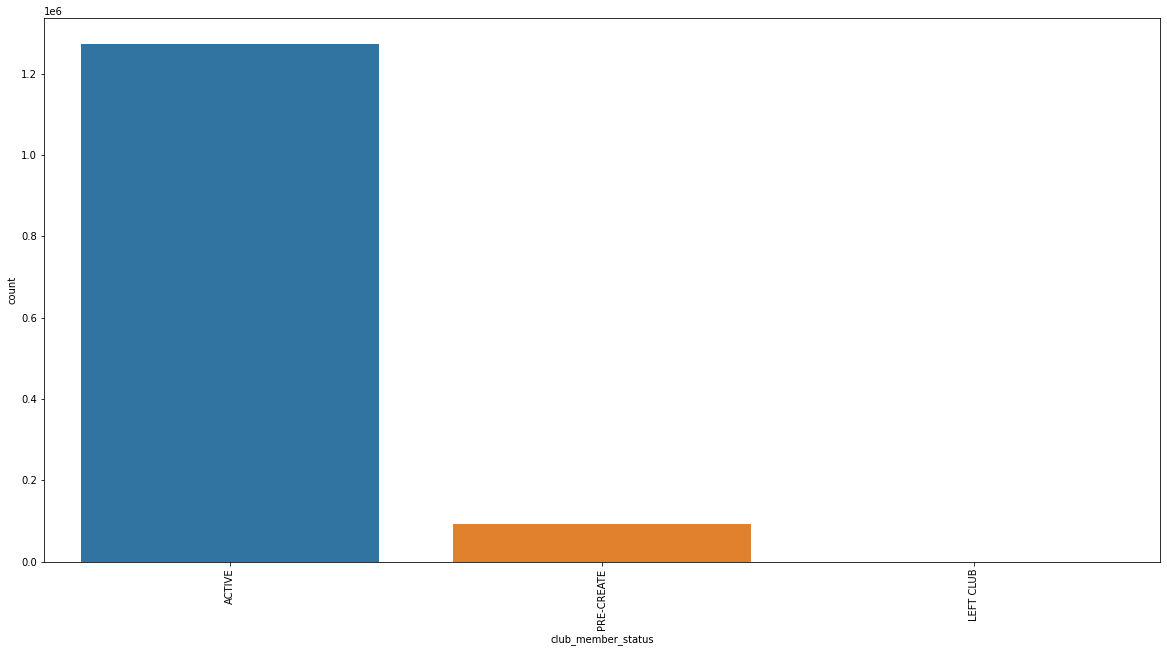

In [156]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(custom["club_member_status"])

### fashion_news_frequency

frequency of fashion news

In [157]:
custom["fashion_news_frequency"].head()

0         NONE
1         NONE
2         NONE
3         NONE
4    Regularly
Name: fashion_news_frequency, dtype: object

In [158]:
custom["fashion_news_frequency"].nunique()

4

In [159]:
custom["fashion_news_frequency"].unique()

array(['NONE', 'Regularly', nan, 'Monthly', 'None'], dtype=object)

In [160]:
custom["fashion_news_frequency"].isnull().sum()

16009

In [161]:
custom[custom["fashion_news_frequency"].isnull()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
37,0001bc8e81a72aaf228a103a85d2ac530c09defffbc6ab...,NaN,NaN,ACTIVE,NaN,60.0,34e570387afde3ed8922147c726c74c88c79800d8aeb56...
197,0008383d133df1285f2f3d28ef5f50916630069d3a5c7f...,NaN,NaN,ACTIVE,NaN,25.0,ee81fa9805503fa73eefcde729c01a786692d5853d96f4...
369,0011de63f72ba2f8802076bfd5659485012feb52cd0f49...,NaN,NaN,ACTIVE,NaN,30.0,d7f7bb9a248ec629cb7e8a1f10be3de2936d0954de9955...
398,0012d74ac44959de7ae07dc0fda7e82afff92189196522...,NaN,NaN,ACTIVE,NaN,23.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
...,...,...,...,...,...,...,...
1371677,fff15f528e303627d0dc8b0e9a69fd878a05085b42e72a...,NaN,NaN,PRE-CREATE,NaN,32.0,c134c3cf14a2645597a6979b7597e3dcdbffd2aa631fc5...
1371705,fff2e1f1cd77950a5116764cb5fe856d9a4b80fc17a1a1...,NaN,NaN,ACTIVE,NaN,28.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1371710,fff2f4f6d84297f48bed3ad3b1b37574536f1d41afbee4...,NaN,NaN,ACTIVE,NaN,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1371788,fff67693cb122cc9a939988a5e2194c044e0881b3f1d5f...,NaN,NaN,ACTIVE,NaN,33.0,2e53e877dc18f4fc84780ee6be958ccf61591d0cc738f0...


In [162]:
custom[custom["fashion_news_frequency"]=="None"]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
898114,a79d9cbfaceb0d25a91caccfad167d4d6391fd5bb4292b...,1.0,NaN,ACTIVE,None,38.0,58b7c5c27f8b5e8118a9786379601a344ab2e141550d93...
1356686,fd2371195b3d046afbb75fb0b9b6a3386275aaae19cd5a...,1.0,1.0,ACTIVE,None,64.0,170a318776b1acf12fb92fe25eb39ff88fd363b530573e...


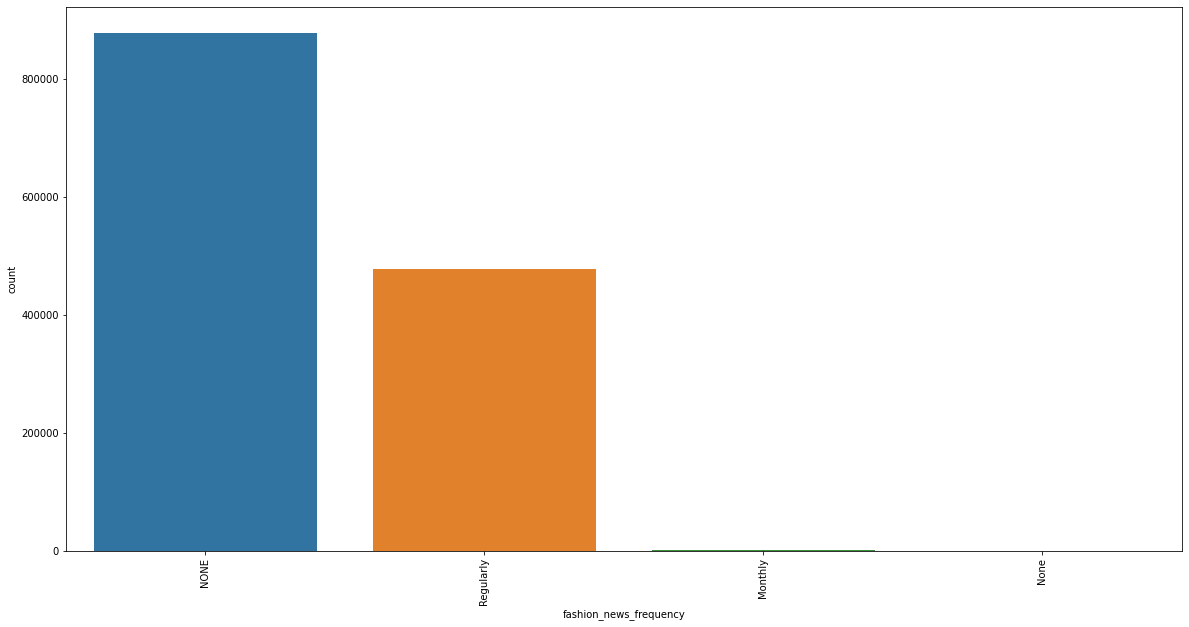

In [163]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(custom["fashion_news_frequency"])

### age

Age of customer

In [164]:
custom["age"].head()

0    49.0
1    25.0
2    24.0
3    54.0
4    52.0
Name: age, dtype: float64

In [165]:
custom["age"].nunique()

84

In [166]:
custom["age"].unique()

array([49., 25., 24., 54., 52., nan, 20., 32., 29., 31., 56., 75., 41.,
       27., 30., 48., 35., 22., 40., 38., 45., 68., 55., 19., 60., 44.,
       21., 26., 28., 53., 33., 17., 23., 51., 18., 34., 57., 47., 70.,
       50., 63., 58., 43., 67., 72., 42., 39., 79., 71., 59., 36., 62.,
       37., 46., 73., 64., 74., 61., 85., 69., 76., 66., 65., 82., 16.,
       90., 80., 78., 81., 84., 77., 97., 89., 83., 98., 88., 86., 87.,
       93., 91., 99., 96., 94., 92., 95.])

In [167]:
round(custom["age"].describe(),1)

count    1356119.0
mean          36.4
std           14.3
min           16.0
25%           24.0
50%           32.0
75%           49.0
max           99.0
Name: age, dtype: float64

In [168]:
custom["age"].isnull().sum()

15861

In [169]:
custom[custom["age"].isnull()]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
54,0002b9088196900626214bcdc6d5f3d85f38fb462a4806...,NaN,NaN,ACTIVE,NONE,NaN,db2cef710598164a99187237dd049b68502590eeb41ca3...
99,0004690d2b68d5175697d197a86065595ef7b49c7c051b...,NaN,NaN,PRE-CREATE,NONE,NaN,d831ea0a55a7a7af0e3ff9da0d370e225242bbc7999d78...
138,0005cd85a6220e1f1c582c7ff9175efe7d7c16d184c5ba...,NaN,NaN,ACTIVE,NONE,NaN,ee66d2b71f2fe333bee3e0f4a2dbac1fcf022e0df38763...
148,00060d2f1e63f2b95268b8573996b9aa5612a3efc97c71...,NaN,NaN,PRE-CREATE,NONE,NaN,f2288fb8f9b8ee2c3e56d6aa813d2a22f820cdfabf27a6...
...,...,...,...,...,...,...,...
1371583,ffecf38e80a8d73c9c6fb6db193e559dbd5374747b4b88...,NaN,NaN,PRE-CREATE,NONE,NaN,f1aed4d6848c484f218f9f9de2820c3f072ece21a043f4...
1371637,ffefa8fa76909f9b9b3c14680d3e00dae891de5d1522f9...,NaN,NaN,PRE-CREATE,NONE,NaN,d83ed3f6f943055853438d25031e896102bb960d07074a...
1371712,fff2f8b52ac6983cf9b2332d1a9bfe0ef38349a8d5392e...,NaN,NaN,ACTIVE,NONE,NaN,3802682b139e3cd0631970d555e4af072475e4dd92ea0a...
1371888,fffb069903e91c2ea4d665851b821c3f812e184119e5a8...,NaN,NaN,PRE-CREATE,NONE,NaN,0e6ad38084bfc681be59ae67f0225049cee4dfef044c29...


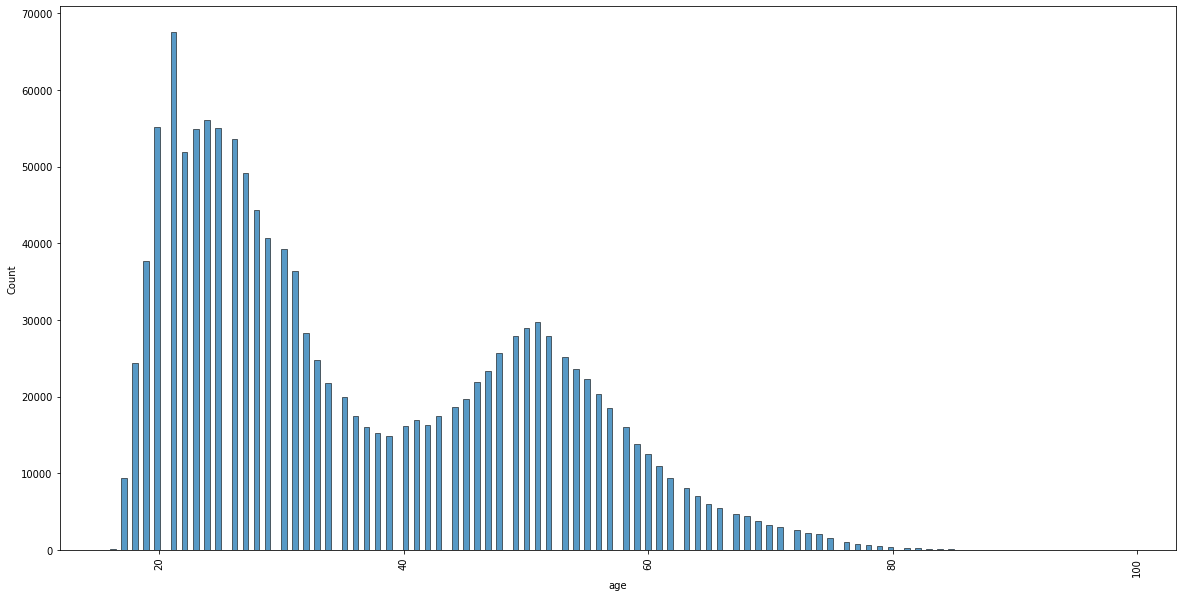

In [170]:
fig=plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig=sns.histplot(custom["age"])

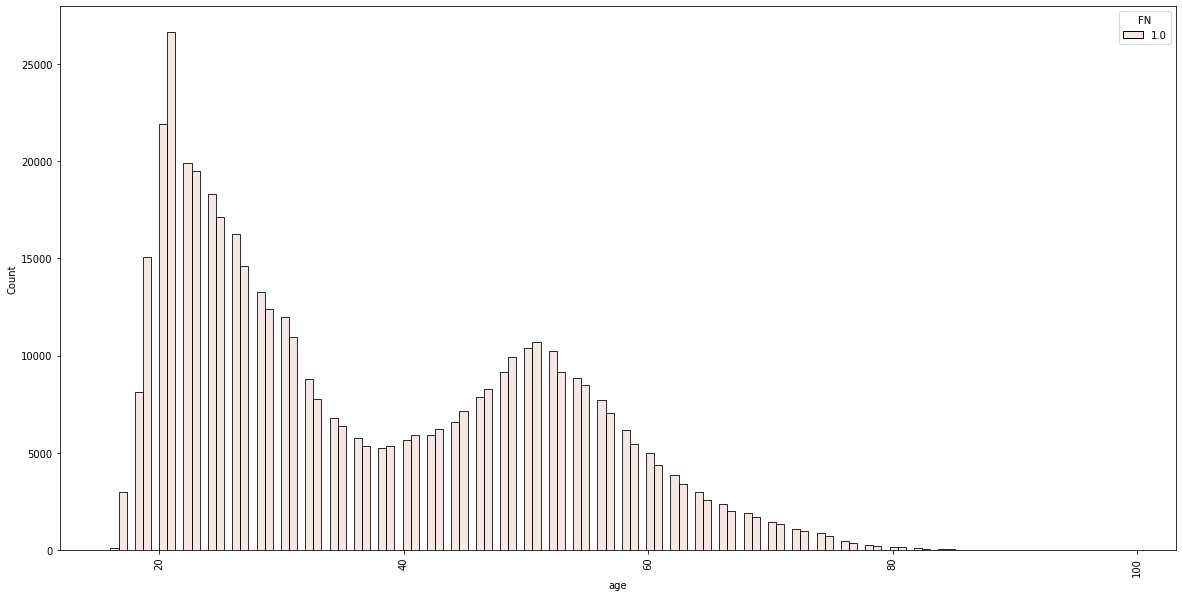

In [171]:
fig=plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig=sns.histplot(data= custom, x="age", hue="FN")

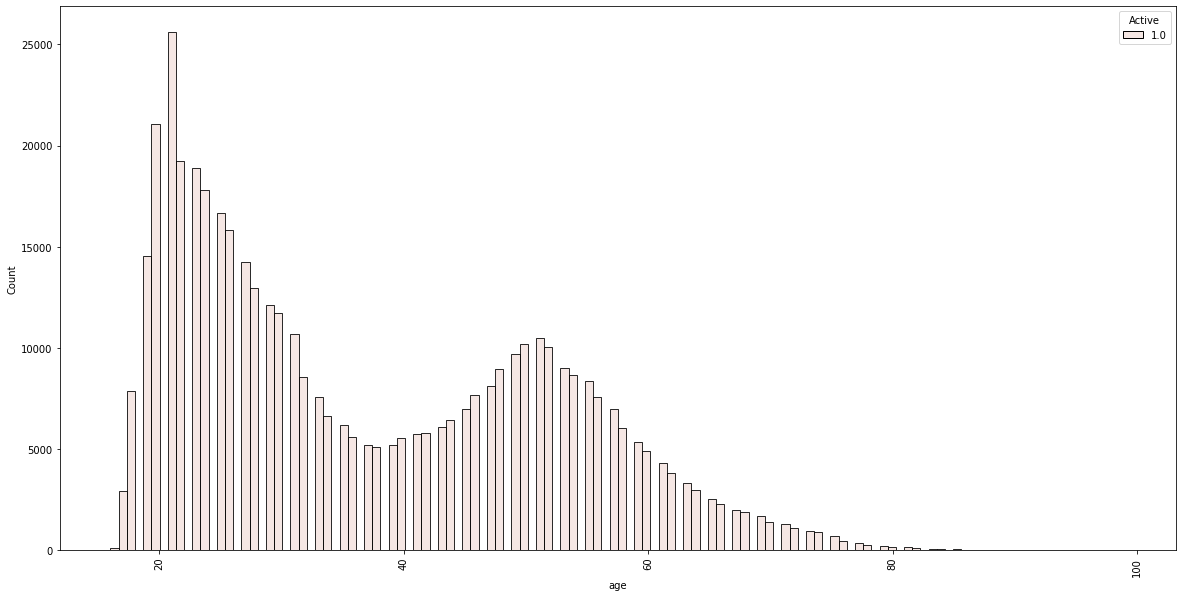

In [172]:
fig=plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig=sns.histplot(data= custom, x="age", hue="Active")

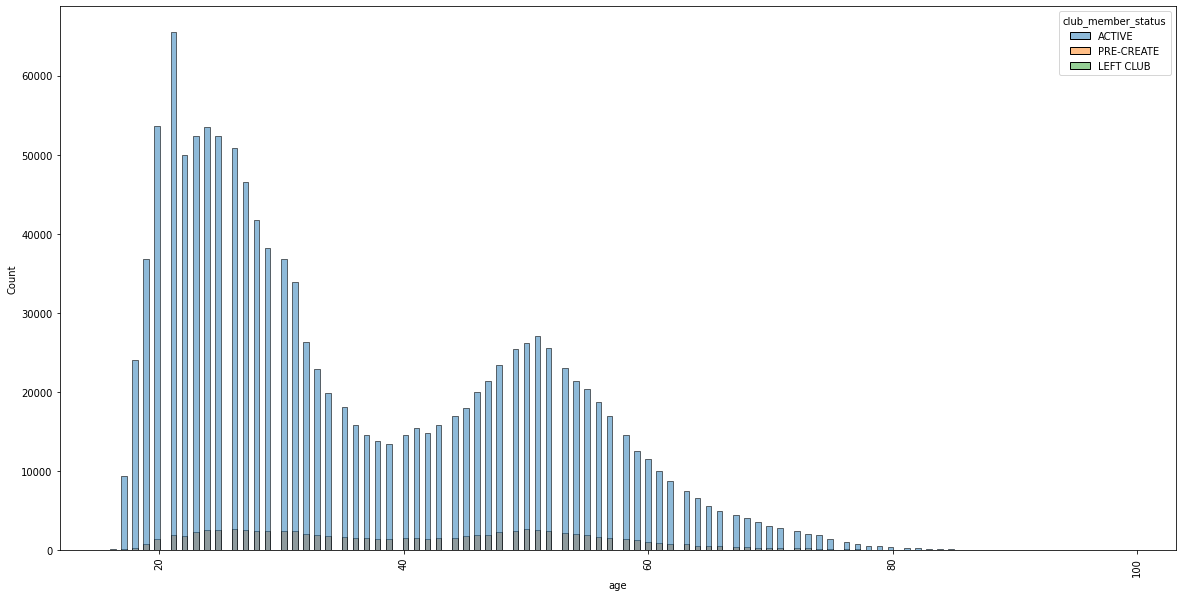

In [173]:
fig=plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig=sns.histplot(data= custom, x="age", hue="club_member_status")

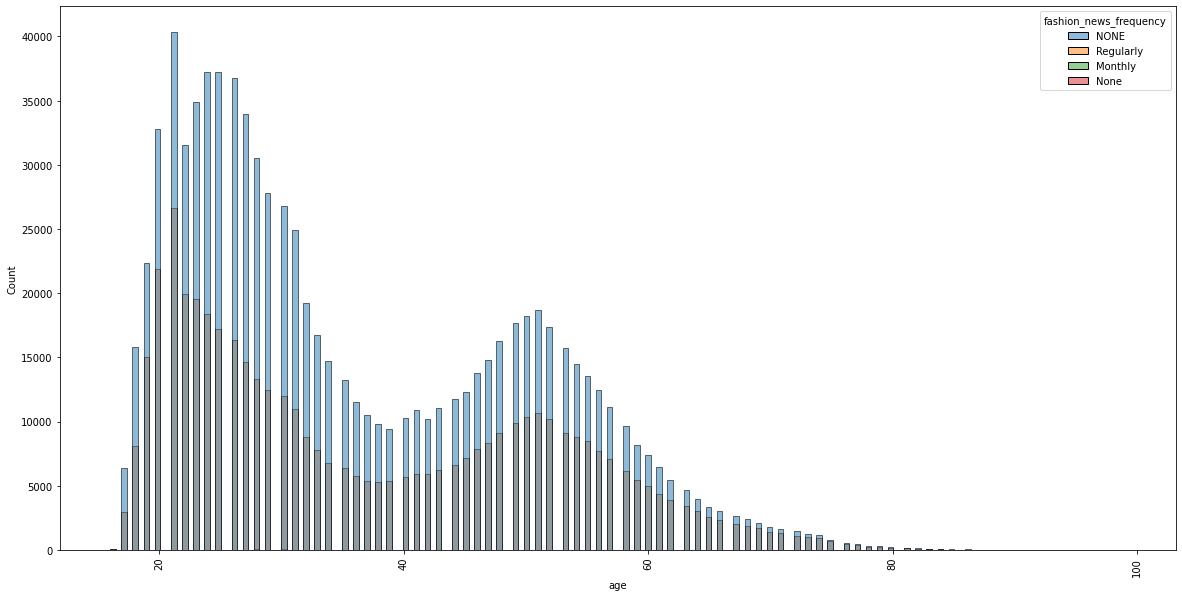

In [174]:
fig=plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig=sns.histplot(data= custom, x="age", hue="fashion_news_frequency")

### postal_code

Zip code as hash

In [175]:
custom["postal_code"].head()

0    52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1    2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2    64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3    5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4    25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
Name: postal_code, dtype: object

In [176]:
custom["postal_code"].nunique()

352899

In [177]:
custom["postal_code"].isnull().sum()

0

In [178]:
custom["postal_code"].duplicated().sum()

1019081

## Transaction 

### General description of te transaction_train.csv

In [179]:
trans.shape

(31788324, 5)

In [180]:
trans.size

158941620

In [181]:
trans.memory_usage(index=True, deep=True).sum()/1e+6

4863.6137

In [182]:
trans.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [183]:
trans.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.5 GB


In [184]:
round(trans.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
article_id,31788324.0,6.962272e+08,1.334480e+08,108775015.0,6.328030e+08,7.145820e+08,7.865240e+08,9.562170e+08
price,31788324.0,3.000000e-02,2.000000e-02,0.0,2.000000e-02,3.000000e-02,3.000000e-02,5.900000e-01
sales_channel_id,31788324.0,1.700000e+00,4.600000e-01,1.0,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00


In [185]:
round(trans.describe( include=np.object).T,2)

,count,unique,top,freq
customer_id,31788324,1362281,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,1895


In [186]:
trans.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [187]:
trans.nunique()

t_dat                   734
customer_id         1362281
article_id           104547
price                  9857
sales_channel_id          2
dtype: int64

## Columns description

|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
|[t_dat](#tdat) |	object |	Transaction date|	734 | needs to be transformed|
|[customer_id](#customerid) |	object |	Custumer ID|	1362281| primary key|
|[article_id](#articleid) |	int64|	article_id |	104547| secondary key|
| [price](#price) |	float64 |	price | 	9857| is transformed or different currency|
|[sales_channel_id](#saleschannelid) |	int64|	2 is online and 1 store|	2| encoding to 0 &1 ?|

### t_dat

Transaction date

In [188]:
trans["t_dat"].head()

0   2019-07-25
1   2020-03-21
2   2020-03-21
3   2020-03-21
4   2018-12-27
Name: t_dat, dtype: datetime64[ns]

In [189]:
trans["t_dat"].nunique()

734

In [190]:
trans["t_dat"].isnull().sum()

0

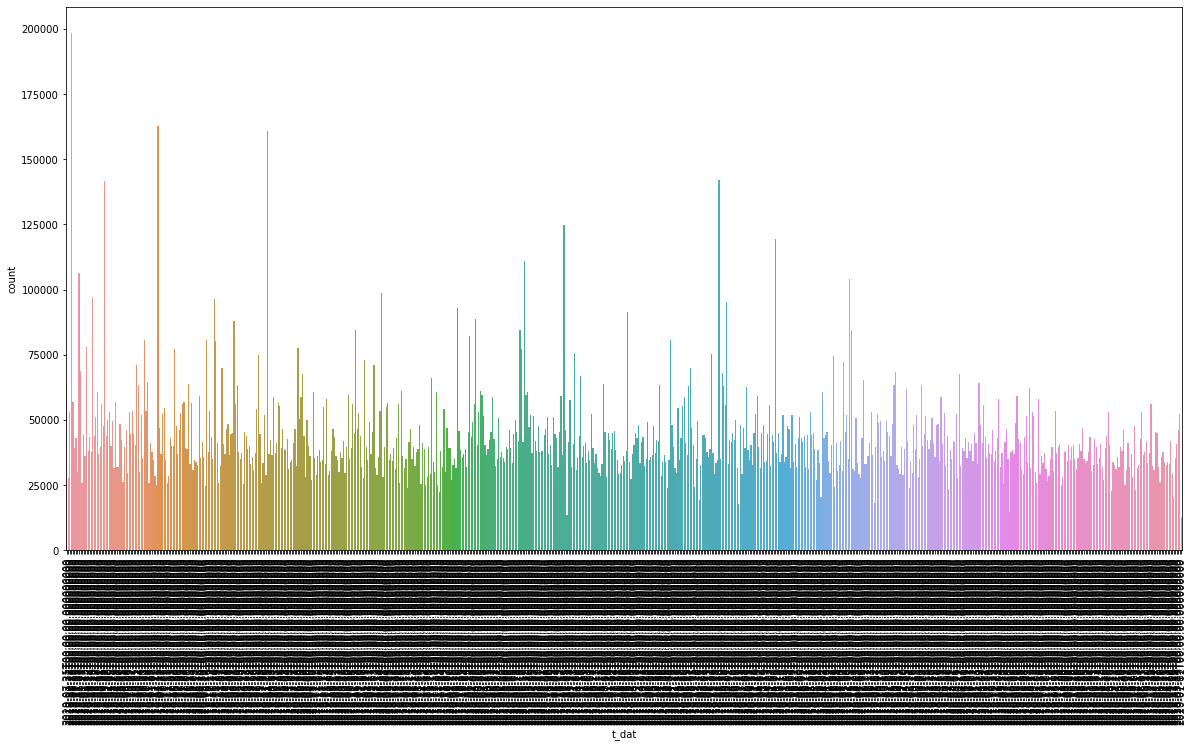

In [194]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot(trans["t_dat"])

In [195]:
#fig = plt.figure(figsize=(20,10))
#fig =plt.xticks(rotation=90)
#fig= sns.histplot( data=trans, x= "t_dat", bins=24, kde=True)

### price

Article price, but transformed or not euro, dollar etc. :) 

In [196]:
trans["price"].head()

0    0.021169
1    0.031763
2    0.021593
3    0.011508
4    0.044051
Name: price, dtype: float64

In [197]:
trans["price"].nunique()

9857

In [198]:
round(trans["price"].describe(),3)

count    3.178832e+07
mean     2.800000e-02
std      1.900000e-02
min      0.000000e+00
25%      1.600000e-02
50%      2.500000e-02
75%      3.400000e-02
max      5.920000e-01
Name: price, dtype: float64

In [199]:
trans["price"].isnull().sum()

0

### sales_channel_id

Origin of purchase 1 = store , 2 = online

In [200]:
trans["sales_channel_id"].head()

0    1
1    2
2    2
3    2
4    1
Name: sales_channel_id, dtype: int64

In [201]:
trans["sales_channel_id"].nunique()

2

In [202]:
trans["sales_channel_id"].unique()

array([1, 2])

In [203]:
trans["sales_channel_id"].isnull().sum()

0

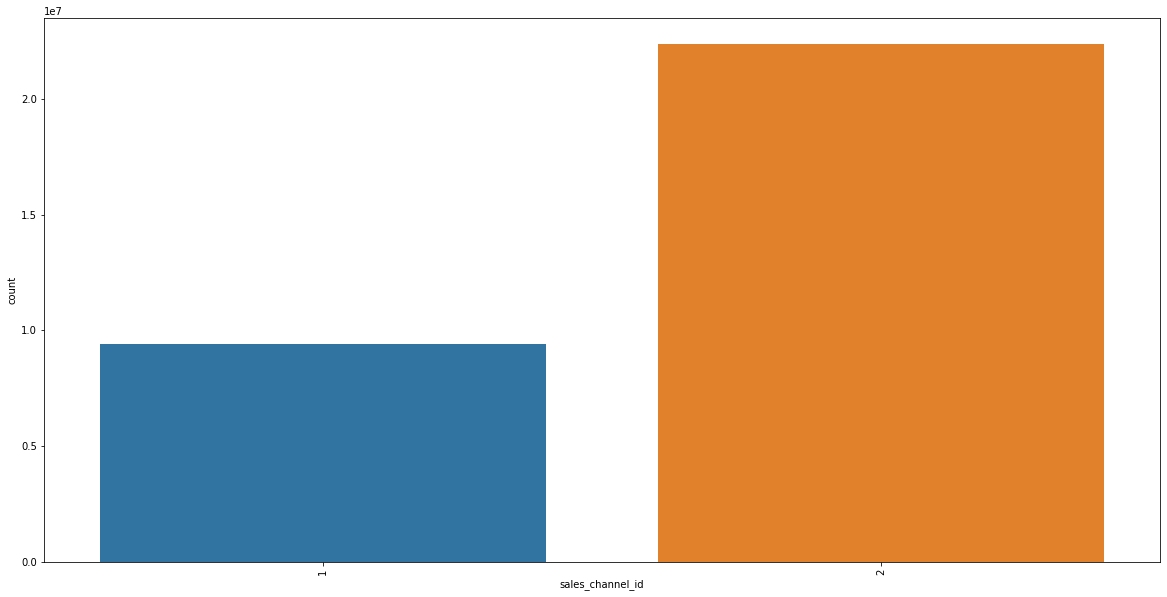

In [204]:
fig = plt.figure(figsize=(20,10))
fig =plt.xticks(rotation=90)
fig= sns.countplot( data=trans, x= "sales_channel_id")

## Sample

### General description of the sample_submission.csv

In [205]:
sample.shape

(1371980, 2)

In [206]:
sample.size

2743960

In [207]:
sample.memory_usage(index=True, deep=True).sum()/1e+6

423.941948

In [208]:
sample.columns

Index(['customer_id', 'prediction'], dtype='object')

In [209]:
sample.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  1371980 non-null  object
 1   prediction   1371980 non-null  object
dtypes: object(2)
memory usage: 404.3 MB


In [210]:
round(sample.describe().T,2)

,count,unique,top,freq
customer_id,1371980,1371980,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1
prediction,1371980,1,0706016001 0706016002 0372860001 0610776002 07...,1371980


In [211]:
sample.isnull().sum()

customer_id    0
prediction     0
dtype: int64

|Column name| Datatyp| Meaning | nunique| annotation|
|----------|-------| ---- |----|---|
| [customer_id](#customerid) | object | Customer ID | 1371980 | hashed Customer ID|
| [prediction](#prediction)| object |Gives the prediction of the top 12 products| 1| |

### preidiction

Gives the prediction of the top 12 products

In [212]:
sample["prediction"].head()

0    0706016001 0706016002 0372860001 0610776002 07...
1    0706016001 0706016002 0372860001 0610776002 07...
2    0706016001 0706016002 0372860001 0610776002 07...
3    0706016001 0706016002 0372860001 0610776002 07...
4    0706016001 0706016002 0372860001 0610776002 07...
Name: prediction, dtype: object

In [213]:
sample["prediction"].nunique()

1

In [214]:
sample["prediction"].unique()

array(['0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'],
      dtype=object)

## parquet

To transform the big data frames to a binary file parquet is used.

In [215]:
articles.to_parquet("../parquet/articles.parquet")

In [216]:
custom.to_parquet("../parquet/custom.parquet")

In [217]:
trans.to_parquet("../parquet/transaction.parquet")

In [218]:
sample.to_parquet("../parquet/sample.parquet")

Cleanng up the messe :) 

In [219]:
#import gc
#gc.collect()